# Import libraries

In [2]:
%matplotlib inline
import json
import numpy as np
import scipy as sp
import datetime
import matplotlib.pyplot as plt
import operator
import os
import pandas as pd
import sys
import string
import copy
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import operator
import seaborn as sns
import operator
from collections import defaultdict

# Import Custom packages

In [3]:
# change the following path to your local repository of energyanalytics
mod_path = '/Users/Simo/Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation'
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
    
from bayesian_cp_detect import bayesian_cp_3 as bcp
from bayesian_cp_detect import cp_detect
# make sure that the code is loaded to the lastest version
reload(bcp)

<module 'bayesian_cp_detect.bayesian_cp_3' from '/Users/Simo/Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation/bayesian_cp_detect/bayesian_cp_3.pyc'>

In [5]:
# change the following path to your local repository of energyanalytics
mod_path = '/Users/Simo/Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation'
import pandas as pd
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
import Util
reload(Util)
test = Util.EquotaData()
test.get_appliance_data()
test.compute_total(appliance_list = test.appliance_list)
test_data = pd.concat([test.data[app]["P"].fillna(method='ffill') for app in test.appliance_list], axis=1, keys=test.appliance_list).fillna(method = "ffill").resample("30S").pad().fillna(0)
test_data["total"] = test_data.sum(axis=1)
reload(Util)
temp = Util.CombinatorialOptimization({"1":[0,550],"2":[0,40],"3":[0,600],"4":[0,1000]})
ans = temp.power_disaggregate(test_data["total"].values)

1999 1999


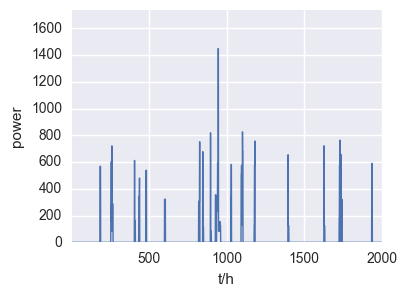

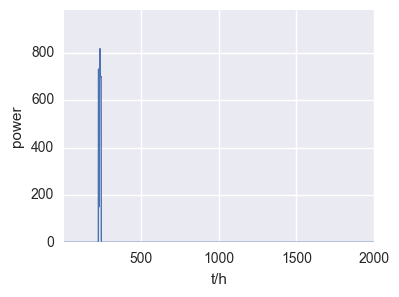

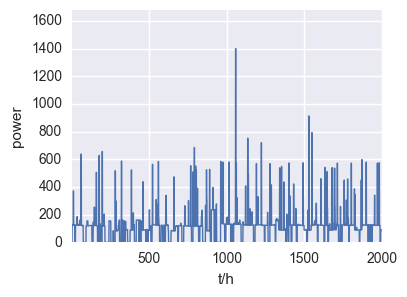

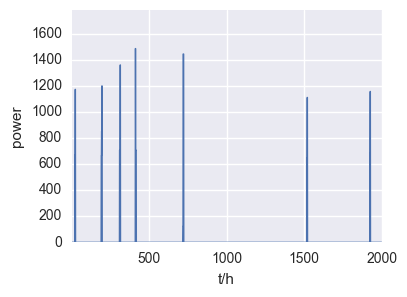

In [10]:
period = 1999
for i in range(len(ans)):
    plot_dissagregation([ans[i]],np.array([i+1 for i in range(max(period,len(ans[i])))]))

# Some helper functions

In [8]:
reload(bcp)
def wdayformat(tm_wday):
    if tm_wday==1:
        strwday='Mon'
    elif tm_wday==2:
        strwday='Tue'
    elif tm_wday==3:
        strwday='Wed'
    elif tm_wday==4:
        strwday='Thu'
    elif tm_wday==5:
        strwday='Fri'
    elif tm_wday==6:
        strwday='Sat'
    elif tm_wday==7:
        strwday='Sun'            
    return strwday

def readfile(f,Col): #read .csv files
    data=[]
    time=[]
    #head=''
    lines = f.readlines()
    #label=[]
    #head+=lines[0]
    for line in lines[1:]:
        line=line.strip('\n')
        line=line.split(',')
        tmp_time=float(line[0])
        tmp_data=0
        for i in range(len(Col)):
            tmp_data+=float(line[Col[i]])
        data.append(tmp_data),
        time.append(tmp_time),
    f.close()
    return (time,data)

def rel_change(y):
    """
    return relative change comparing to the closer neighbouring points
    """
    return np.min([np.abs(y[1] - y[0]), np.abs(y[1] - y[2])]) / float(y[1])

def rel_change_filter_0819_3(t, data_input, thre=.2):
    """
    filter data based on relative change
    data points in data_input that below or above both neighbouring points
    and have relative change above thre will be set as the average of neighbouring data.
    """
    thre_2 = thre/(1-thre)
    id_filter = [i for i in range(1, len(data_input)-1) 
     if (data_input[i]>data_input[i-1] and data_input[i]>data_input[i+1] and rel_change(data_input[i-1:i+2])>thre) or
                 (data_input[i]<data_input[i-1] and data_input[i]<data_input[i+1] and rel_change(data_input[i-1:i+2])>thre_2)
    ]
    data_input_2 = [(data_input[i-1]+data_input[i+1])/2 if (i in id_filter) else dat for i, dat in enumerate(data_input) ]
    return t, data_input_2

def initial_disaggregate(t_all,y_all,num_day,period = 1440):
    
    #date_current = date_start
    day = 0
    all_dat_seg = []
    while day < num_day:
        #print 'reading: ', date_current

        #t, y = read_dat_0819(date_current, 0, 23, '../new_data/IHG')
        t=np.array([i+1 for i in range(period)])
        y=y_all[(day)*period:(day+1)*period]
        t_2, y_2 = rel_change_filter_0819_3(t,y)
        mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
        changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
        changepoint.append(len(t_2)-1)

        if len(changepoint)>1:
            dat_seg = [[y[cp_start:cp_end], y[cp_start-3:cp_start]] for cp_start, cp_end in zip(changepoint[:-1], changepoint[1:])]
        else:
            dat_seg = []
        all_dat_seg.extend(dat_seg)

        #date_current+=datetime.timedelta(1)
        day+=1
        
    return all_dat_seg

def plot_24h_data(t, raw_data,cp_list):
    fig, axes = plt.subplots(nrows=4, figsize=[18, 10])
    
    for i, ax in enumerate(axes):
        #ax.plot(t, data, 'r-', markersize=3, linewidth=1, label='smooth')
        ax.plot(t, raw_data, 'k.', markersize=3, label='raw')
        
        for cp in cp_list:
            ax.plot([t[cp], t[cp]], [0, max(raw_data)*1.2], 'k-', linewidth=1)
        ax.set_ylabel('power')
        ax.set_xlim([0+i*len(raw_data)/4,len(raw_data)/4+i*360])
    ax.set_xlabel('time/h')
    plt.legend()
    
def extract_first_n(data_list, n):
    return [t[:n] for t in data_list if len(t)>=n]


# integrated functions:
def integrated_clustering(t_all,y_all,num_of_days=500,period = 1440,trim=10,min_n_clusters = 4, max_n_clusters=10,hierarchical=0):
    all_seg_april = initial_disaggregate(t_all,y_all,num_of_days,period = period)
    all_seg_april_normalized = [np.array(x[0])-np.mean(x[1]) for x in all_seg_april if len(x[1])==3]
    all_seg_april_normalized = [x for x in all_seg_april_normalized if len(x)>0]
    if hierarchical == 0:
        pass
    elif hierarchical ==1:
        all_seg_april_normalized = [x for x in all_seg_april_normalized if x.mean()>1000]
    else:
        all_seg_april_normalized = [x for x in all_seg_april_normalized if x.mean()<1000]
    
    all_positive_seg_april_normalized = [x for x in all_seg_april_normalized if x.min()>0]
    
    
    all_seg_april_normalized_trim50 = extract_first_n(all_positive_seg_april_normalized, trim)
    cluster_average = []
    
    # find optimal clustering number using silhouette score
    
    optimal_dict = {}
    
    for n_clusters in range(min_n_clusters,max_n_clusters):
        
        y_pred = KMeans(n_clusters=n_clusters).fit_predict(all_seg_april_normalized_trim50)

        cluster_average = []
        for i_cluster in range(n_clusters):
            cluster_average.append(
                np.mean([np.mean(x) for i, x in enumerate(all_seg_april_normalized_trim50) if y_pred[i]==i_cluster])
            ) 

        # sihouette score
        cluster_labels = y_pred
        sample_silhouette_values = silhouette_samples(all_seg_april_normalized_trim50, cluster_labels)
        
        silhouette_avg = silhouette_score(pd.DataFrame(all_seg_april_normalized_trim50), cluster_labels)

        optimal_dict[n_clusters] = silhouette_avg +(sample_silhouette_values.min()+sample_silhouette_values.max())/2
    
    
    n_clusters = max(optimal_dict.iteritems(), key=operator.itemgetter(1))[0]

    #print n_clusters
    
    y_pred = KMeans(n_clusters=n_clusters).fit_predict(all_seg_april_normalized_trim50)

    cluster_average = []
    
    for i_cluster in range(n_clusters):
        cluster_average.append(
            np.mean([np.mean(x) for i, x in enumerate(all_seg_april_normalized_trim50) if y_pred[i]==i_cluster])
        ) 
    cluster_average_rank = np.argsort(cluster_average)[::-1]
    rank_map = {cluster_average_rank[i_cluster]:i_cluster for i_cluster in range(n_clusters)} # old index:new index

    y_pred_old = y_pred
    y_pred = [rank_map[x] for x in y_pred]
    all_seg_per_cluster = [[] for i in range(n_clusters) ]
    for i_seg in range(len(all_seg_april_normalized_trim50)):
        all_seg_per_cluster[y_pred[i_seg]].append(all_seg_april_normalized_trim50[i_seg])
        
    cluster_mean = [[] for i in range(n_clusters) ]
    cluster_std = [[] for i in range(n_clusters) ]
    for i_cluster in range(n_clusters):
        cluster_mean[ i_cluster ] = np.mean(np.array(all_seg_per_cluster[i_cluster]), axis=0)
        cluster_std[ i_cluster ] = np.std(np.array(all_seg_per_cluster[i_cluster]), axis=0)
    
    
    
    
    #cluster_mean_2 = cluster_mean[5:6]
    
    return cluster_mean,cluster_std,n_clusters,all_seg_per_cluster

def plot_cluster_result(cluster_mean,cluster_std,n_clusters,all_seg_per_cluster,trim):    
    cluster_len = trim
    color_list = sns.color_palette("hls", n_clusters)

    fig, ax = plt.subplots(nrows=5,ncols=4,figsize=[20,12]);
    ax = ax.flatten()

    for i_cluster in range(n_clusters):
        ax_current = ax[i_cluster]

        for seg in all_seg_per_cluster[i_cluster]:
            ax_current.plot(seg, '-', linewidth=1, alpha=.3, color=color_list[i_cluster])
        ax_current.set_xlim([0, cluster_len])
        ax_current.set_ylim([-50, 40])
        ax_current.plot([0,50], [0,0], 'k--')    
        ax_current.plot(cluster_mean[i_cluster], color=color_list[i_cluster])
        ax_current.fill_between(range(cluster_len)
                                , cluster_mean[i_cluster]-cluster_std[i_cluster]
                                , cluster_mean[i_cluster]+cluster_std[i_cluster]
                                , color=color_list[i_cluster], alpha=.8)
def n_dimension_identity_matrix(cluster_mean_2):
    to_return_list  = []
    for i in range(1,len(cluster_mean_2)+1):
        to_return_list.append([0 if j!=i else 1 for j in range(1,len(cluster_mean_2)+1)])
    return to_return_list

def DP_state_generation(N):
    if N==1:
        return [[0],[1]]
    else:
        return_list = DP_state_generation(N-1)
        toreturn = []
        for i in return_list:
            #print i
            i.append(0)
            toreturn.append(copy.copy(i))
            i.pop()
            i.append(1)
            #print i
            toreturn.append(copy.copy(i))
                
        #print toreturn
        return toreturn

def generate_state_prob_list(N):
    toreturn = {}
    toreturnlist = DP_state_generation(N)
    k = 1/float(len(toreturnlist))
    for i in toreturnlist:
        toreturn[tuple(i)] = k
        
    return toreturn

def integrated_dissagregate(y_all,period,cluster_mean_2,day = 65,n_equipment_type = 4,n_equipment = [2,2,2,2],obs_mat = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]),power_usage = [0,0,0,0],alpha = 10,r_blur = 30):
    
    opt = bcp.set_disaggregation_option(change_shape=cluster_mean_2, 
                               init_pos_std = np.sqrt([float(200/3), float(200/3), float(400/3), float(400/3)])
                                )
    
    t=np.array([i+1 for i in range(period)])
    data=y_all[(day)*period:(day+1)*period]
    cp_list = bcp.disaggregate(data,opt)
    
    #TEST CODE
    print cp_list
    
    t=np.array([i+1 for i in range(period)])
    y=y_all[day*period:(day+1)*period]
    t_2, y_2 = rel_change_filter_0819_3(t,y)
    mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=r_blur)
    changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
    if len(changepoint)>0 and changepoint[-1]!=len(t_2)-1:
        changepoint.append(len(t_2)-1)
    cp_list_test = changepoint
    plot_24h_data(t_2,y_2,cp_list)
    plot_24h_data(t_2,y_2,changepoint)
    
    print cp_list_test # cp_list_test is the changepoint obtained by the original bcp algorithm
    cp_list = cp_list_test
    #
    data_seg, n_seg, data_seg_raw_last = bcp.segment_data(data, cp_list)
    new_data_seg, new_n_seg, new_data_seg_raw_last = bcp.segment_data_new(data, cp_list)
    shape_matched = cluster_mean_2
    n_shape_matched = len(shape_matched)
    all_shape_code = bcp.shape_code_gen(n_shape_matched)
    shape_dict = bcp.combine_shape(shape_matched, all_shape_code)
    shape_prob_list = bcp.get_seg_prob(data_seg, shape_dict)
    
    new_shape_prob_list = bcp.get_seg_prob_positive(new_data_seg, shape_dict)
    
    #print shape_prob_list
    
    
    
    #shape_prob_list = bcp.get_seg_prob(data_seg, shape_dict)
    
    
    
    state_prob_list = generate_state_prob_list(len(cluster_mean_2))
    
    
    #obs_mat = np.array([[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0],[0,0,0,0,1]])
    
    for item,keys in state_prob_list.iteritems():
        state_prob_list[item] = new_shape_prob_list[0][item]
    
    #trace_list, shape_list = bcp.viterbi(shape_prob_list, new_shape_prob_list[0], data_seg, obs_mat)
    #trace_list, shape_list = viterbi_new(shape_prob_list,state_prob_list,new_shape_prob_list,data_seg,obs_mat,power_usage)
    trace_list, shape_list = viterbi_for_missing_change_point(shape_prob_list,state_prob_list,new_shape_prob_list,data_seg,obs_mat,power_usage,alpha = alpha)
    
    predicted_profile = bcp.generate_predicted_profile(cp_list, shape_matched, shape_list, data, n_equipment_type, obs_mat, trace_list)
    
    return predicted_profile

def plot_dissagregation(predicted_profile,t):
    plt.figure(figsize = [4,3])
    maxval = 0
    for tmp in predicted_profile:
        maxval = max(maxval,max(tmp))
        plt.plot(t,tmp,linewidth = 1)
    #plt.plot(t,data,'k.',markersize = 2)
    
    plt.xlim([1,max(t)+1])
    plt.ylim([0,maxval*1.2])
    plt.xlabel('t/h')
    plt.ylabel('power')
    
def plot_dissagregation_2(predicted_profile,t):
    plt.figure(figsize = [16,8])
    for key,tmp in predicted_profile.iteritems():
        plt.plot(t,tmp,linewidth = 1)
    #plt.plot(t,data,'k.',markersize = 2)

    plt.xlim([1,1500])
    plt.ylim([0,3000])
    plt.xlabel('t/h')
    plt.ylabel('power')

def viterbi_for_missing_change_point(shape_prob_list, state_prob_list, boot_state_prob_list, data_seg, obs_mat, power_usage,alpha = 100):
    # originally shape means the 'change', state means the actual usage...
    #print "inside of function viterbi for missing change point"
    #print "shape_prob_list",shape_prob_list
    #print "data_seg",data_seg
    n_seg = len(data_seg)
    
    state_prob_list_list = [state_prob_list]
    state_memory_list_list = []
    shape_memory_list_list = []
    
    for i_seg in range(n_seg):
        seg_mean = np.mean(data_seg[i_seg])

        next_state_prob_list = {t:0 for t in state_prob_list.keys()}
        state_memory_list = {t:0 for t in state_prob_list.keys()} #
        shape_memory_list = {t:0 for t in state_prob_list.keys()} #

        for next_state, next_state_prob in next_state_prob_list.items():

            max_prob = -float('Inf')
            max_past_state = tuple()
            max_shape = ()
            #print max(shape_prob_list[i_seg].iteritems(),key = operator.itemgetter(1))[0]
            for shape_code, shape_prob in shape_prob_list[i_seg].items():# loop through all possible changes...
                #print obs_mat,shape_code
                change_state = np.dot(obs_mat, shape_code) # if the obs_mat is identity matrix then the change_state = shape_code
                past_state = tuple(np.subtract(next_state, change_state))  # find out the corresponding past_state
                if past_state in state_prob_list: # the past state should be all positive
                    if state_prob_list[past_state] * shape_prob + alpha*boot_state_prob_list[i_seg][next_state]  > max_prob:
                        max_prob = state_prob_list[past_state] * shape_prob + alpha*boot_state_prob_list[i_seg][next_state]
                        max_past_state = past_state
                        max_shape = shape_code
            state_memory_list[next_state] = max_past_state  # the table 2, noting down the most possible past state
            next_state_prob_list[next_state] = max_prob     
            shape_memory_list[next_state] = max_shape

        #print '##############'
        
        computed = sum(map(operator.mul,max(state_prob_list.iteritems(),key = operator.itemgetter(1))[0],power_usage))
        observed = sum(map(operator.mul,max(boot_state_prob_list[i_seg].iteritems(),key = operator.itemgetter(1))[0],power_usage))
        #print max(state_prob_list.iteritems(),key = operator.itemgetter(1))[0]
        #print max(boot_state_prob_list[i_seg].iteritems(),key = operator.itemgetter(1))[0]
        #print computed
        #print observed

        #if (float(computed)-float(observed))/float(observed)<0.3:
            
        state_prob_list = next_state_prob_list
        
        #print '##############'
        state_prob_list_list.append(next_state_prob_list)
        state_memory_list_list.append(state_memory_list)
        shape_memory_list_list.append(shape_memory_list)


    trace_list = []
    shape_list = []

    end_state = sorted(state_prob_list_list[-1].items(), key=operator.itemgetter(1))[-1][0]
    trace_list.insert(0, end_state)
    #print "end state",end_state
    #print "shape_memory_list_list",shape_memory_list_list
    #print "state_memory_list_list",state_memory_list_list
    
    for i in reversed(range(n_seg)):
        #print "error"
        print shape_memory_list_list[i]
        max_shape = shape_memory_list_list[i][end_state]
        end_state = state_memory_list_list[i][end_state]
        trace_list.insert(0, end_state)
        shape_list.insert(0, max_shape)

    return trace_list, shape_list

def l2_distance(list_1, list_2, last_point_w = 50, n=2):
    dis = 0
    tmp = [(x-y)**n for x,y in zip(list_1, list_2)]
    dis = np.sum( tmp )
    if len(list_1) >= len(list_2):
        dis+=last_point_w*(list_1[-1] - list_2[-1])**n
    return dis / (len(tmp)+last_point_w)

# usage_list = {'1':[50,100],'2':[1500,1700]...}
def backend_construct_equip_to_shape_map(cluster_mean,usage_list,shape_max = 2):
    
    equip_to_shape_map = {}
    
    for appliance_name,appliance_usage in usage_list.iteritems():
        equip_to_shape_map[appliance_name] = []
        usage_array = [float(appliance_usage[0]+appliance_usage[1])/2.0 for i in cluster_mean_2[0]]
        distance_dict = {row+1: l2_distance(cluster_mean[row],usage_array,last_point_w = 1)  for row in range(len(cluster_mean_2))}
        local_shape_max = shape_max
        while local_shape_max>0:
            temp = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
            equip_to_shape_map[i].append(temp)
            del distance_dict[temp]
            local_shape_max=local_shape_max-1
        return equip_to_shape_map
    
# add new cluster_result to old cluster_result
def backend_add_new_cluster_result(old_cluster_mean,new_cluster_mean):
    
    for new_data in new_cluster_mean:
        distance_dict = {row+1: l2_distance(old_cluster_mean[row],new_data,last_point_w = 1) for row in range(len(old_cluster_mean))}
        temp_min_distance = min(distance_dict.iteritems(),key = operator.itemgetter(1))[1]
        if float(temp_min_distance)/float(l2_distance([0 for i in old_cluster_mean[0]],new_data))>0.1:
            old_cluster_mean.append(new_data)
            #temp = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
        return new_data

    
        
def construct_equip_to_shape_map(cluster_mean_2,exact_usage_list):
    equip_to_shape_map = {}
    #equip_to_shape_map = defaultdict(list)
    #picked_list = [i for i in range(1,len(exact_usage_list)+1)]
    # only use non zero value to compute mean
    #mean_list=[np.array([y for y in x if y>0]).mean() for x in exact_usage_list]
    mean_list=[i.mean() for i in cluster_mean_2]
    #mean_list = [x.mean() for x in exact_usage_list]
    #
    for i in range(1,len(exact_usage_list)+1):
        equip_to_shape_map[i] = []
        #mean = cluster_mean_2[i-1].mean()
        non_zero_array = np.array([y for y in exact_usage_list[i-1] if y>0])
        #print non_zero_array
        distance_dict = { row+1 : (exact_usage_list[i-1].max()-mean_list[row])*(exact_usage_list[i-1].max()-mean_list[row]) for row in range(len(cluster_mean_2))}
        #distance_dict = { row+1 : (non_zero_array.mean()-mean_list[row])*(non_zero_array.mean()-mean_list[row]) for row in range(len(cluster_mean_2))}

        temp = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
        equip_to_shape_map[i].append(temp)
        del distance_dict[temp]
        temp = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
        equip_to_shape_map[i].append(temp)
        del distance_dict[temp]
        temp = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
        equip_to_shape_map[i].append(temp)
        #picked_list.remove(equip_to_shape_map[i])
    return equip_to_shape_map

def construct_shape_to_equip_map(cluster_mean_2,exact_usage_list):
    equip_to_shape_map = {}
    picked_list = [i for i in range(1,len(exact_usage_list)+1)]
    # only use non zero value to compute mean
    mean_list=[np.array([y for y in x if y>0]).mean() for x in exact_usage_list]
    #mean_list = [x.mean() for x in exact_usage_list]
    for i in range(1,len(cluster_mean_2)+1):
        mean = cluster_mean_2[i-1].mean()
        distance_dict = { row : (mean_list[row-1]-mean)*(mean_list[row-1]-mean) for row in picked_list }
        equip_to_shape_map[i] = min(distance_dict.iteritems(),key = operator.itemgetter(1))[0]
        
        picked_list.remove(equip_to_shape_map[i])
    return equip_to_shape_map

def get_n_day_origin_data(filename='/Users/Simo/Desktop/equota/disaggrREDD/house1_output15s',filext='.dat',period = 1440,N = 65,AppNo=[3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20]):
    f_input = file(filename+filext,'r')
    #AppNo=[3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20] #Choose App#
    ytemp = []
    for ii in AppNo:
        f_input = file(filename+filext,'r')
        (t_all,y_all)=np.array(readfile(f_input,[i-2 for i in [ii]]))
        t=np.array([i+1 for i in range(period)])
        ytemp.append(y_all[N*period:(N+1)*period])
    return ytemp

# Read in the local Redd Data and plot

In [41]:
# Change the following path to the local REDD file's path
filename='/Users/Simo/Desktop/equota/disaggrREDD/house1_output15s'
filext='.dat'
f_input = file(filename+filext,'r')

# By default we load all the App's data
#AppNo=[3,4,5,6,7,8,9,11,12,13,14,15,16,17,18,19,20] #Choose App#
AppNo=[5,8,10,11,12,15]
period=1440
# set which day you want to plot 
N=1
(t_all,y_all)=np.array(readfile(f_input,[i-2 for i in AppNo]))
# time axis
t=np.array([i+1 for i in range(period)])
# get the data of Nth day
y=y_all[N*period:(N+1)*period]

# one function to read and plot 
def Computeandplotsegments(t_all,y_all,days = 500):

    all_seg_april = initial_disaggregate(t_all,y_all,500)
    all_seg_april_normalized = [np.array(x[0])-np.mean(x[1]) for x in all_seg_april if len(x[1])==3]
    all_seg_april_normalized = [x for x in all_seg_april_normalized if len(x)>0]
    all_positive_seg_april_normalized = [x for x in all_seg_april_normalized if x.min()>0]
    plt.figure(figsize=[8, 6])

    for x in all_seg_april_normalized:
        plt.plot(x, 'k-', linewidth=.5, alpha=.1)

    plt.xlabel('time point after change point')
    plt.ylabel('relative power shift')
    plt.xlim([0, 10])
    plt.ylim([-600, 400])

# read in all data and plot for a specific day and compute the segments from the first 500 days
def ReadandPlot(day = 1,fileext ='.dat',period = 1440, filename = filename,AppNo = AppNo):
    f_input = file(filename+filext,'r')
    (t_all,y_all)=np.array(readfile(f_input,[i-2 for i in AppNo]))
    t=np.array([i+1 for i in range(period)])
    y=y_all[day*period:(day+1)*period]
    t_2, y_2 = rel_change_filter_0819_3(t,y)
    mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
    changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
    changepoint.append(len(t_2)-1)
    plot_24h_data(t_2,y_2,changepoint)
    Computeandplotsegments(t_all = t_all,y_all = y_all,days = 500)
    return t_all,y_all,y

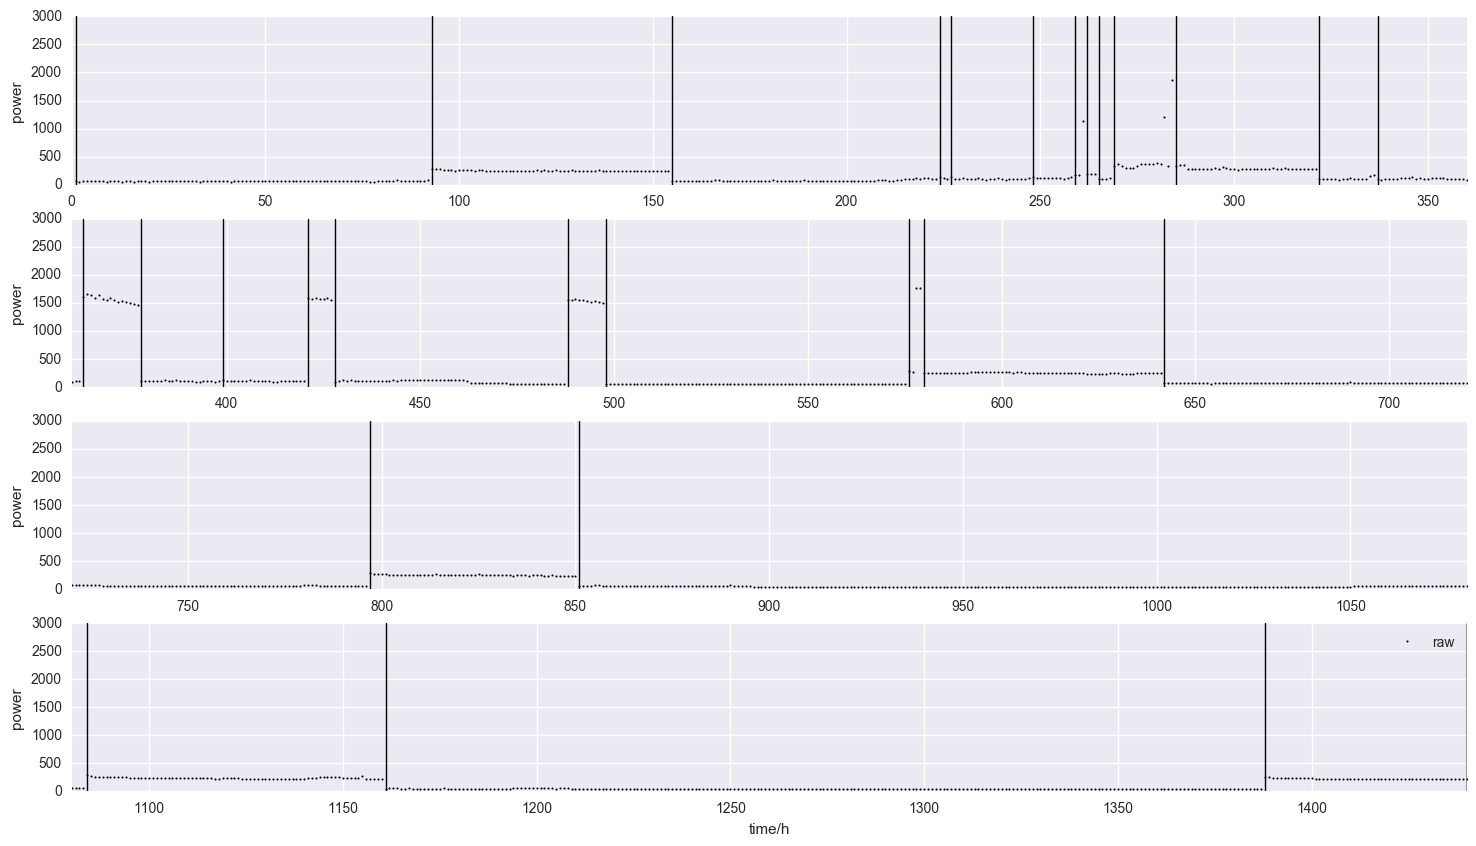

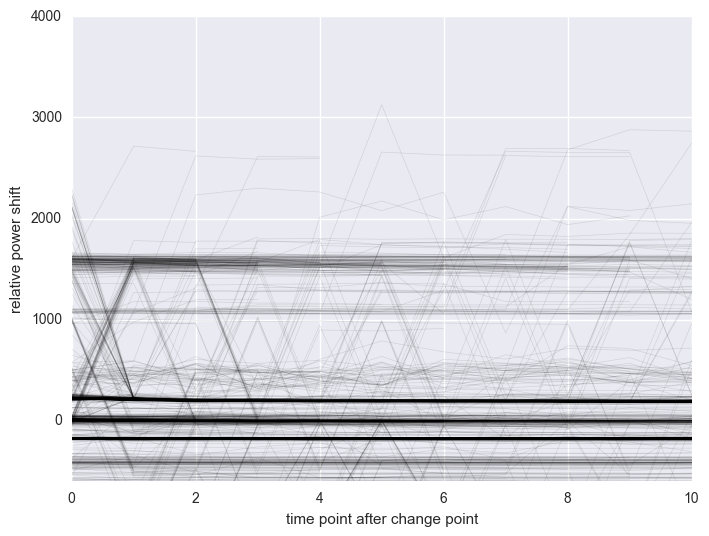

In [13]:
t_all,y_all,day_data = ReadandPlot()

/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:67: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:77: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:89: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in double_scalars


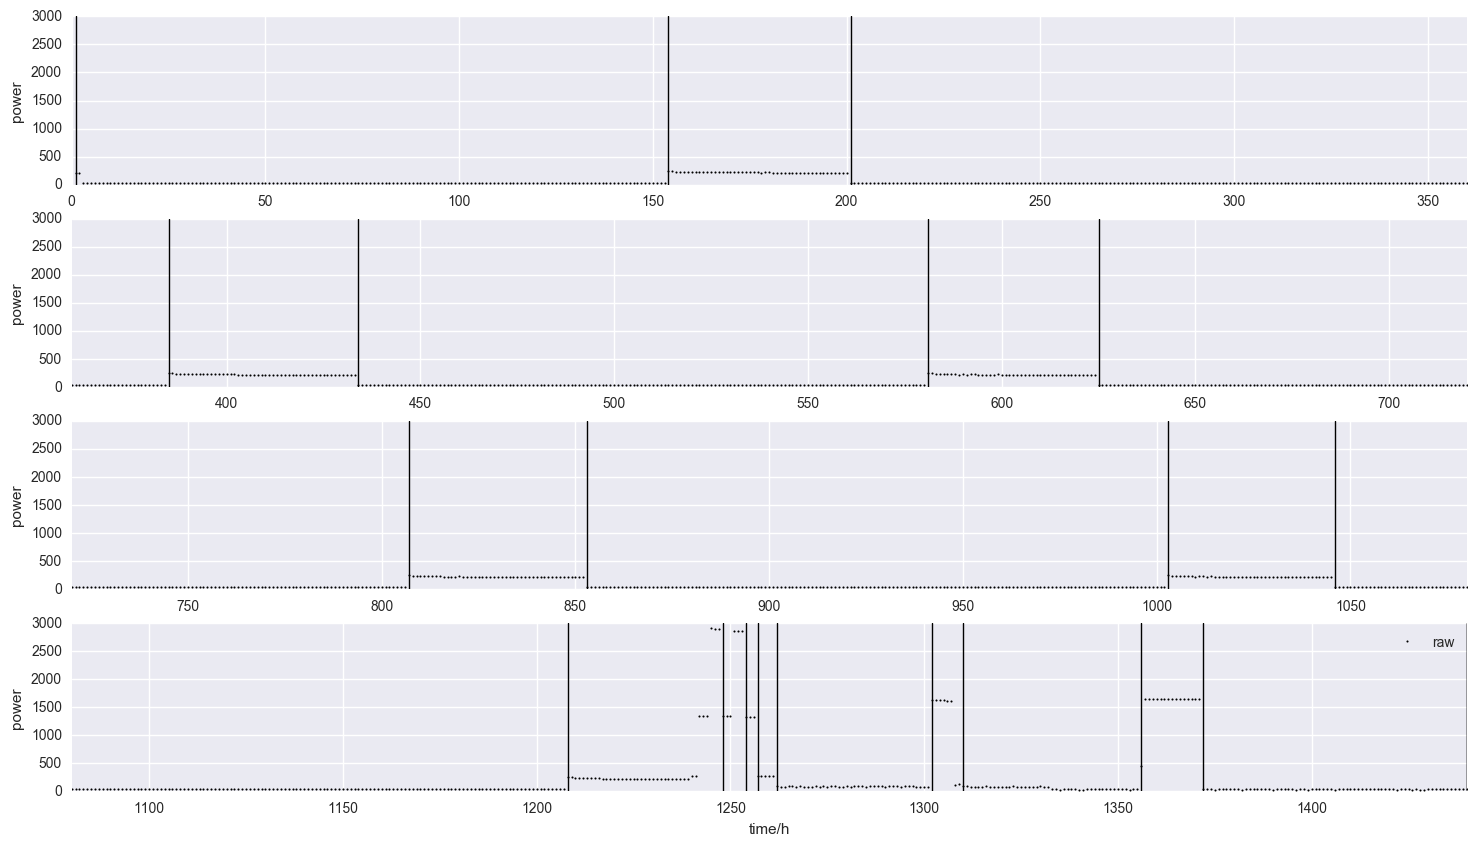

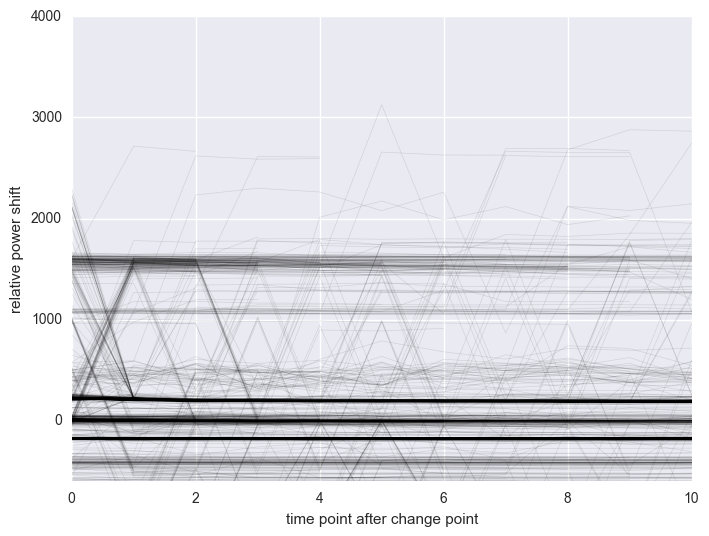

In [5]:
t_all,y_all,day_data = ReadandPlot(day = 2)

# Clustering from history data

5


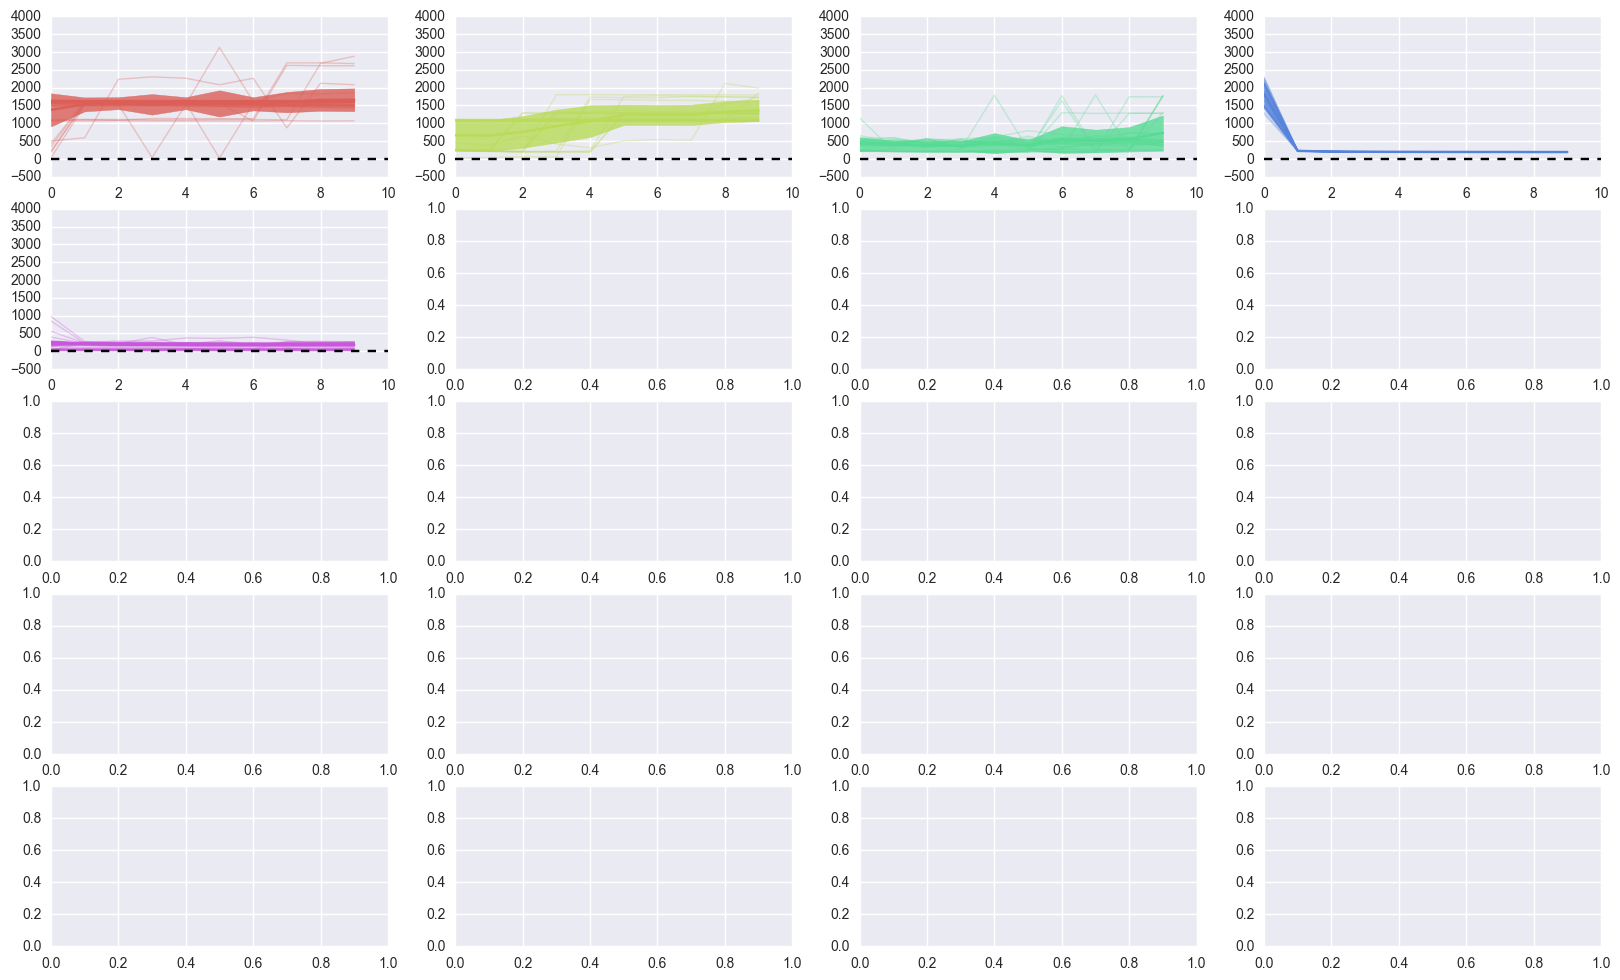

In [6]:
cluster_mean,cluster_std,n_clusters,all_seg_per_cluster = integrated_clustering(t_all,y_all,num_of_days=500,period = 1440,trim=10,min_n_clusters = 5, max_n_clusters=6)
plot_cluster_result(cluster_mean,cluster_std,n_clusters,all_seg_per_cluster)

# construct the mapping between appliances and shapes by hand

In [7]:
cluster_mean_2 = []
cluster_mean_2.append(cluster_mean[0])
cluster_mean_2.append(cluster_mean[1])
cluster_mean_2.append(cluster_mean[2])
cluster_mean_2.append(cluster_mean[3])
cluster_mean_2.append(cluster_mean[4])

# Run the dissagregate on a certain date

/Users/Simo/Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation/bayesian_cp_detect/bayesian_cp_3.py:235: RuntimeWarning: divide by zero encountered in log
  log_prob_grow[i_shape] = [np.log(new_cp_prob)] + log_prob[i_shape][:-1] + [ log_prob[i_shape][-1]+H ]


[0, 8, 18, 121, 136, 151, 157, 163, 169, 175, 199, 208, 214, 231, 247, 255, 261, 450, 735, 1015, 1043, 1053, 1059, 1296]
[0, 11, 122, 134, 152, 170, 198, 230, 248, 256, 451, 515, 736, 798, 1016, 1054, 1076, 1297, 1357, 1439, 1439]


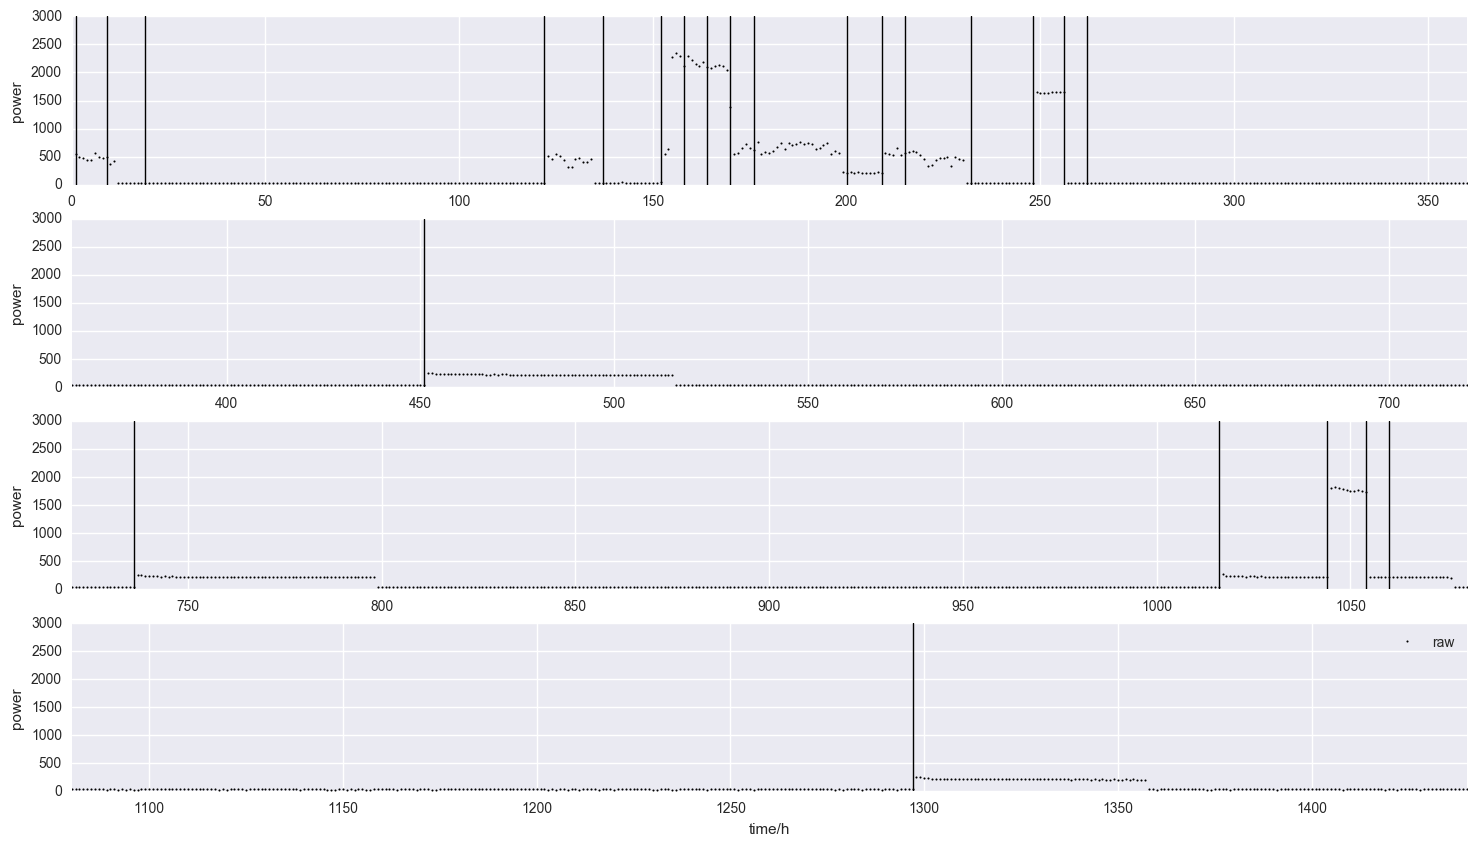

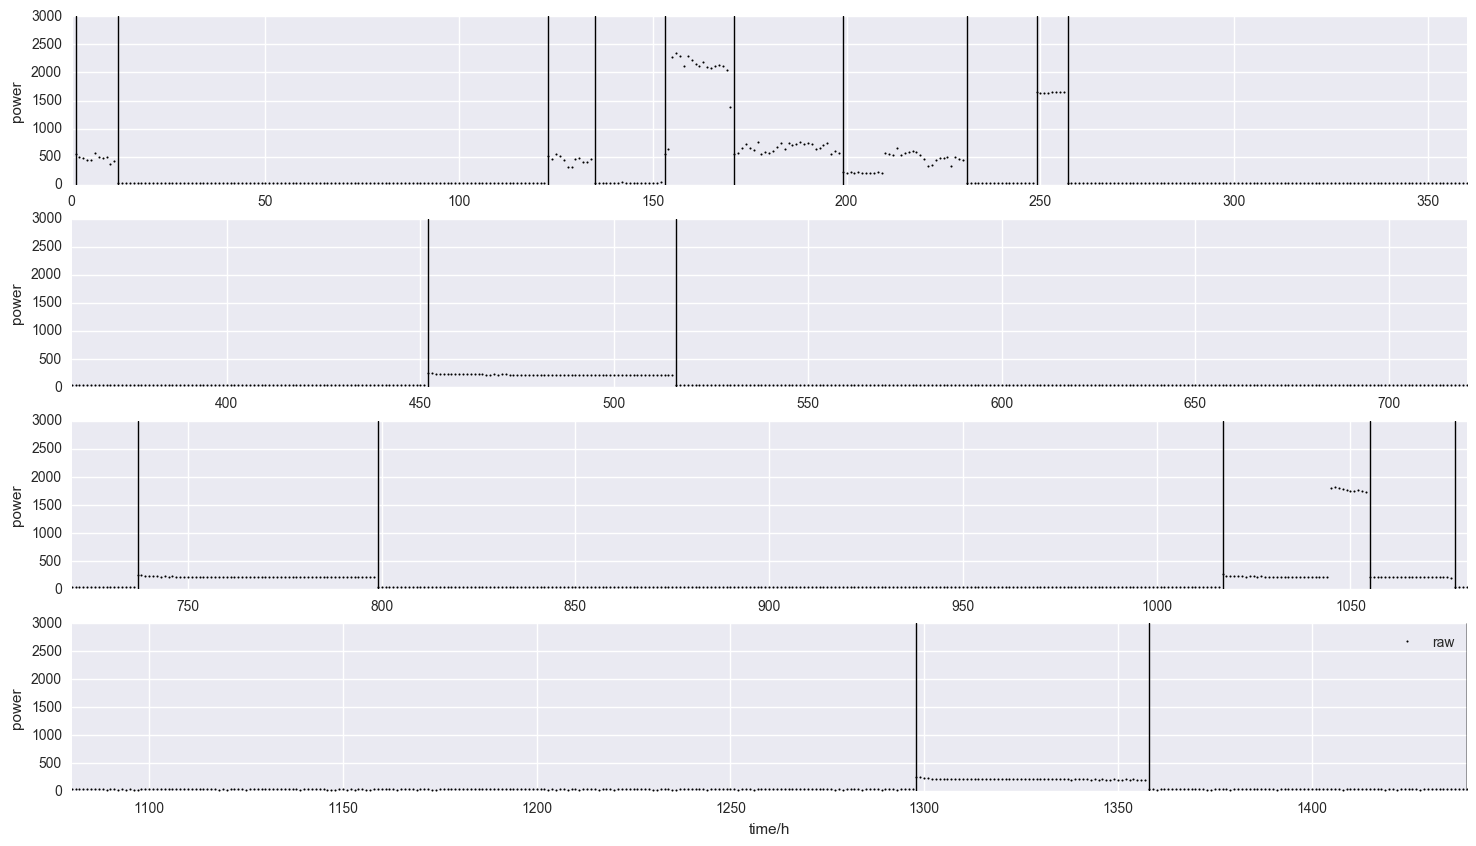

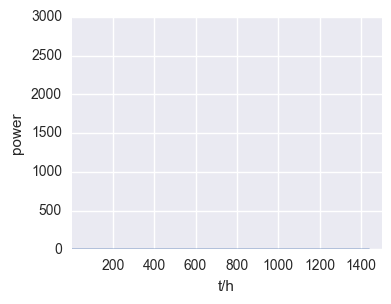

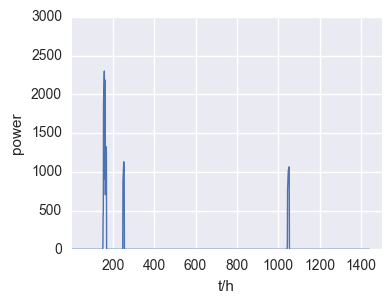

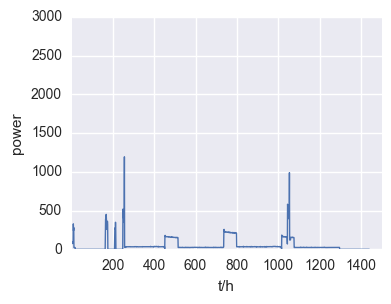

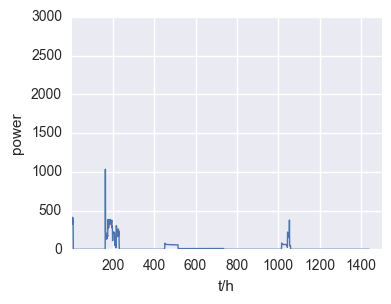

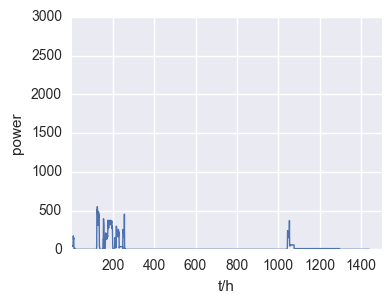

In [8]:
reload(bcp)
# change the parameter day and make sure to construct the cluster_mean_2 before calling this function
predicted_profile = integrated_dissagregate(y_all,1440,cluster_mean_2,day = 41,n_equipment_type = len(cluster_mean_2),n_equipment=[2 for i in range(1,len(cluster_mean_2)+1)],obs_mat=n_dimension_identity_matrix(cluster_mean_2),power_usage = [i.mean() for i in cluster_mean_2])  
for i in range(len(predicted_profile)):
    plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))

# Compare with the real data

In [20]:
#plot the original data for each appliance at Nth day
AppNo=[5,8,10,11,12,15]
def plot_original_data(N,AppNo = [i for i in AppNo]):
    ytemp = get_n_day_origin_data(N = N,AppNo = AppNo)
    
    for index,x in enumerate(ytemp):
        
        plt.figure(figsize=[4, 3])
        plt.plot(x, 'k-', linewidth=.8, alpha=.5)

        plt.xlabel('Usage of appno {}'.format(index))
        plt.ylabel('')
        plt.xlim([0, 1440])
        plt.ylim([-60, 500])

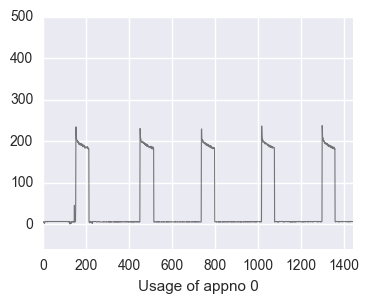

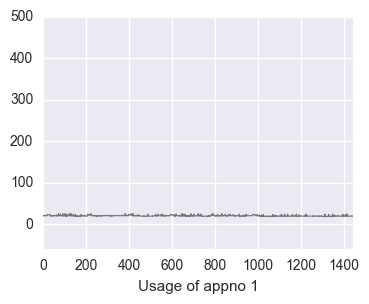

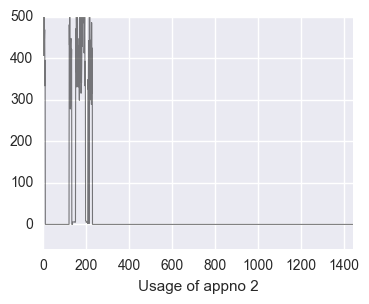

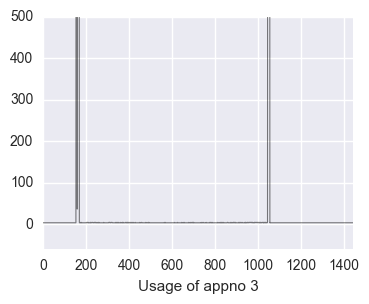

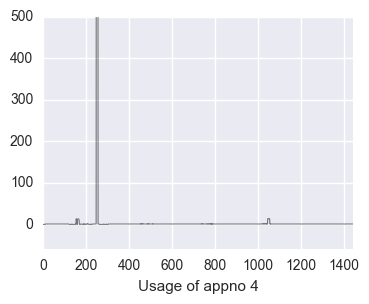

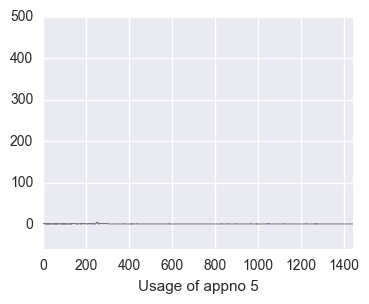

In [26]:
plot_original_data(N=41)

In [28]:
ytemp = get_n_day_origin_data(N = 40,AppNo = [4])

In [31]:

fftresult = np.fft.rfft(ytemp[0])

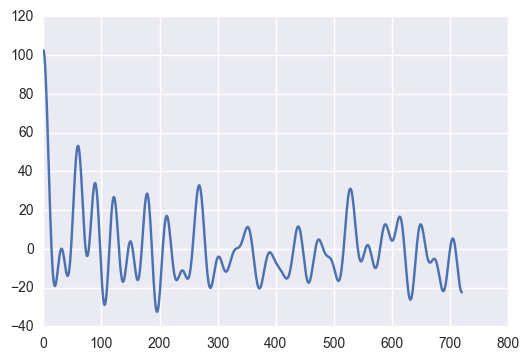

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(ytemp)
# sample spacing
#T = 1.0 / 800.0
#x = np.linspace(0.0, N*T, N)
#y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.rfft(ytemp)
#xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(fftresult)
plt.show()

In [37]:
#plot the original data for each appliance at Nth day

def plot_original_data_spectrum(N,AppNo = [i for i in range(3,20)]):
    ytemp = get_n_day_origin_data(N = N,AppNo = AppNo)
    
    for index,x in enumerate(ytemp):
        
        plt.figure(figsize=[4, 3])
        #plt.plot(x, 'k-', linewidth=.8, alpha=.5)
        plt.plot(np.fft.rfft(ytemp[index]))
        plt.xlabel('Usage of appno {}'.format(index))
        plt.ylabel('')
        plt.xlim([0, 1440])
        plt.ylim([-60, 500])

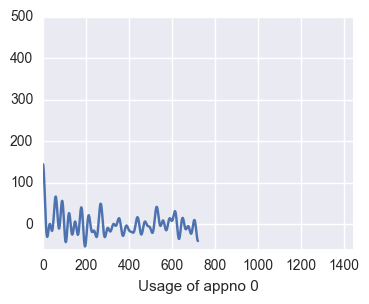

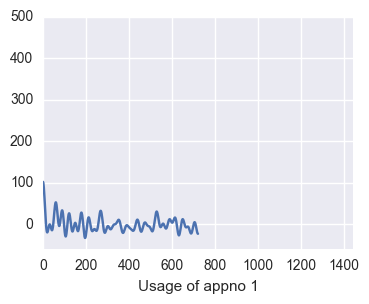

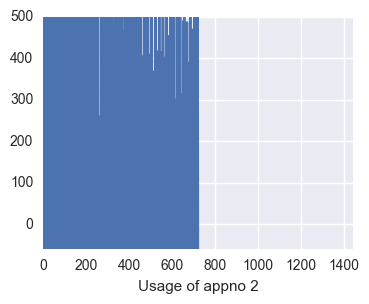

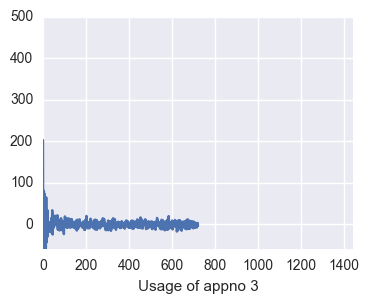

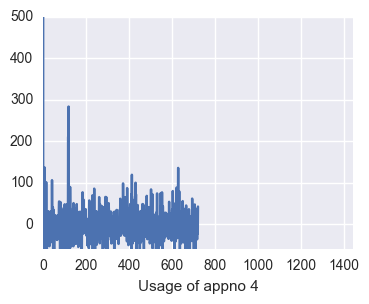

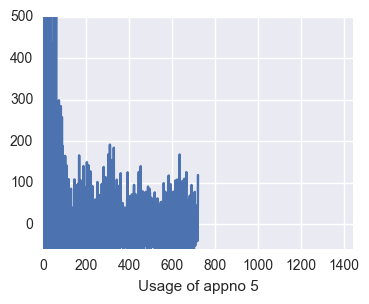

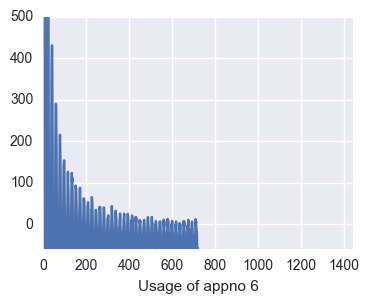

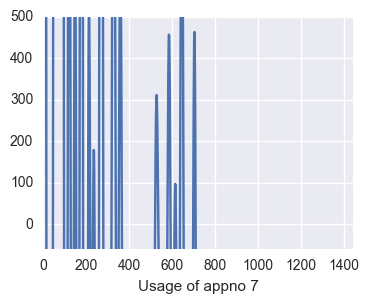

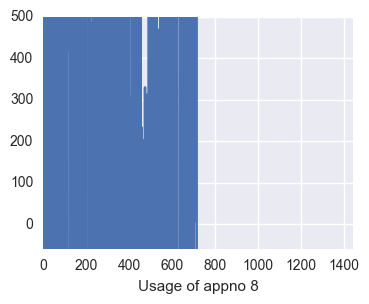

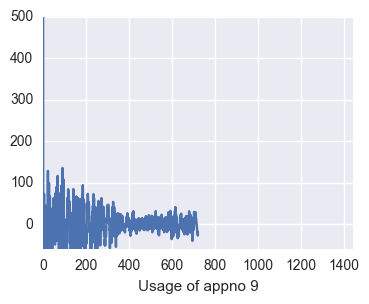

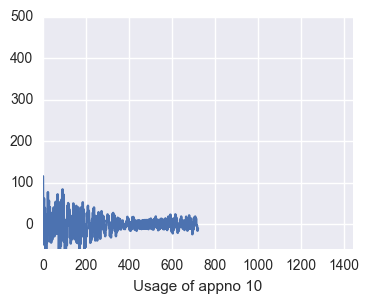

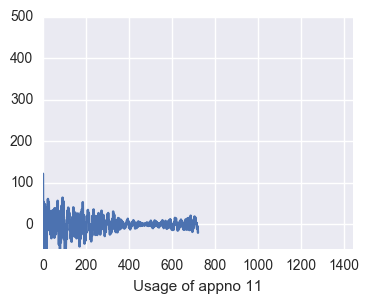

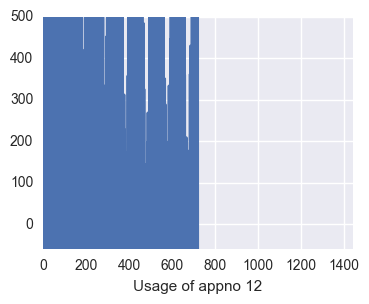

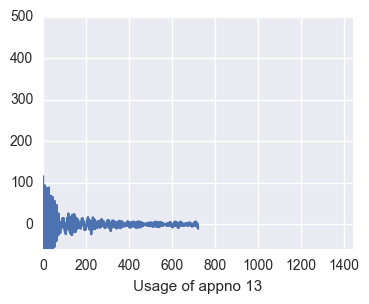

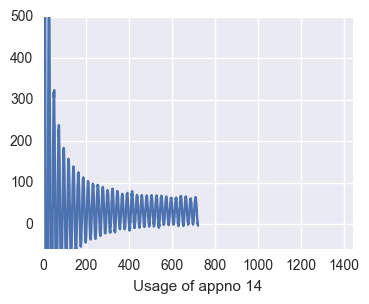

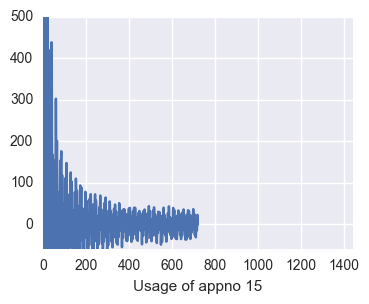

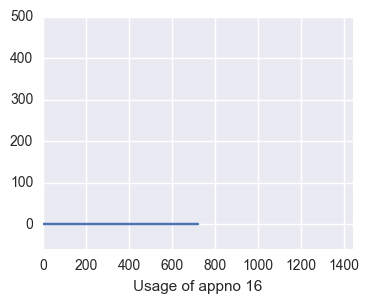

In [38]:
plot_original_data_spectrum(N=40)

In [25]:
import inspect
lines = inspect.getsource(plot_24h_data)
print(lines)

def plot_24h_data(t, raw_data,cp_list):
    fig, axes = plt.subplots(nrows=4, figsize=[18, 10])
    
    for i, ax in enumerate(axes):
        #ax.plot(t, data, 'r-', markersize=3, linewidth=1, label='smooth')
        ax.plot(t, raw_data, 'k.', markersize=3, label='raw')
        
        for cp in cp_list:
            ax.plot([t[cp], t[cp]], [0, 3000], 'k-', linewidth=1)
        ax.set_ylabel('power')
        ax.set_xlim([0+i*360,360+i*360])
    ax.set_xlabel('time/h')
    plt.legend()



In [10]:
# Compute the error
# total correct / total usage for the day
def compute_total_error(period,ytemp,predicted_profile,equip_to_shape_map,total):
    correct_list = []
    sum = 0
    total_sum = total.sum()
    for i in range(period):
        #total_sum+=total[i]
        for j in range(len(predicted_profile)-1):
            sum += max(min(predicted_profile[-1][i],ytemp[j][i]),max([min(ytemp[j][i],predicted_profile[k-1][i]) for k in equip_to_shape_map[j+1]]))
            #sum += max(min(predicted_profile[-1][i],ytemp[j][i]),max([min(ytemp[j][i],predicted_profile[k-1][i]) for k in equip_to_shape_map[j+1]]))
            #sum +=min(ytemp[j][i],predicted_profile[equip_to_shape_map[j+1]-1][i])#min(ytemp[equip_to_shape_map[j+1]-1][i],predicted_profile[j][i])
            #total+= predicted_profile[j][i]
            #error.append(abs(ytemp[j][i]-predicted_profile[equip_to_shape_map[j+1]-1][i])/ytemp[j][i])
        #correct_list.append(float(sum)/float(total[i]))
        #error_list.append(error)
    return float(sum)/float(total_sum)

def compute_total_correct(period,ytemp,predicted_profile,equip_to_shape_map,total):
    correct_list = []
    for i in range(period):
        sum = 0
        for j in range(len(ytemp)-1):
            #sum +=min(ytemp[j][i],predicted_profile[equip_to_shape_map[j+1]-1][i])
            sum += max(min(predicted_profile[-1][i],ytemp[j][i]),max([min(ytemp[j][i],predicted_profile[k-1][i]) for k in equip_to_shape_map[j+1]])) 
        correct_list.append(float(sum)/float(total[i]))
        
    return correct_list

0.706804364036
0.756774225894


(0, 4000)

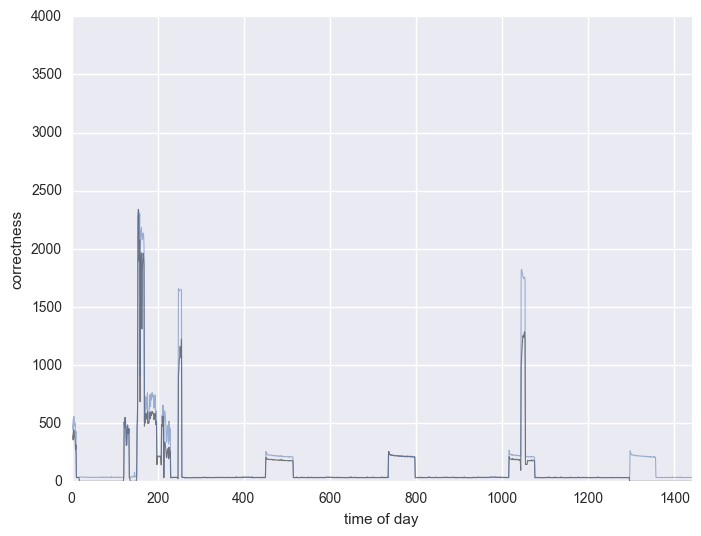

In [12]:
ytemp = get_n_day_origin_data(N = 41,AppNo = AppNo)
day = 41
per = compute_total_error(1440,ytemp,predicted_profile,construct_equip_to_shape_map(cluster_mean_2,ytemp),y_all[(day)*period:(day+1)*period])
print per
x= compute_total_correct(1440,ytemp,predicted_profile,construct_equip_to_shape_map(cluster_mean_2,ytemp),y_all[(day)*period:(day+1)*period])
correct = np.dot(np.array(x),y_all[(day)*period:(day+1)*period])
print correct/y_all[(day)*period:(day+1)*period].sum()
plt.figure(figsize=[8, 6])
#plt.plot([y for y in x],'k-', linewidth=.8, alpha=.5)
plt.plot([y for y in x*y_all[(day)*period:(day+1)*period]],'k-', linewidth=.8, alpha=.5)
plt.plot(y_all[(day)*period:(day+1)*period],linewidth=.8, alpha=.5)
plt.xlabel('time of day')
plt.ylabel('correctness')
plt.xlim([0, 1440])
plt.ylim([0, 4000])

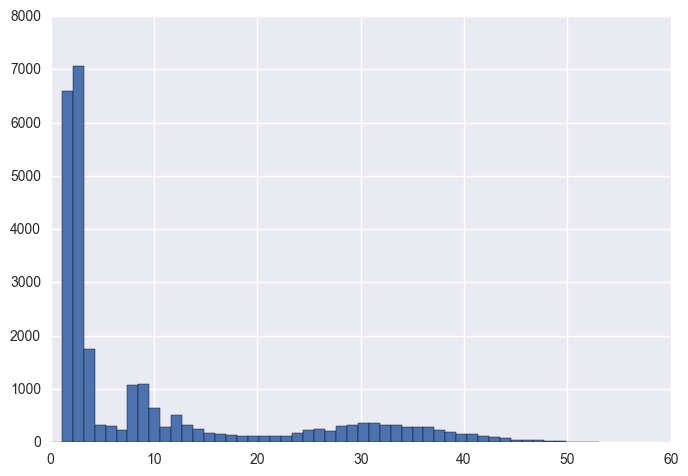

In [80]:
#plt.hist(temp_data['___Ua'],50);
#plt.hist(temp_data['___Ub'],50);
#plt.hist(temp_data['___Uc'],50);
plt.hist(temp_data['___P'],50);

## Plot based on different week of day

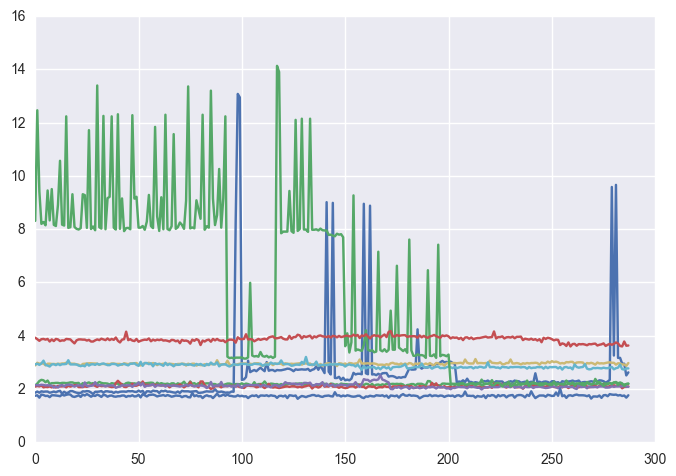

In [311]:
# Plot all the weekday data together
from datetime import timedelta, date
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2018, 6, 1)
end_date = date(2018, 8, 1)

# Friday
for single_date in daterange(start_date, end_date):
    if single_date.weekday() in [5]:
        plt.plot(temp_data[single_date.strftime("%Y-%m-%d")]["___P"].values) 
#plt.plot(temp_data[temp_data['weekday']==2]["___P"])

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


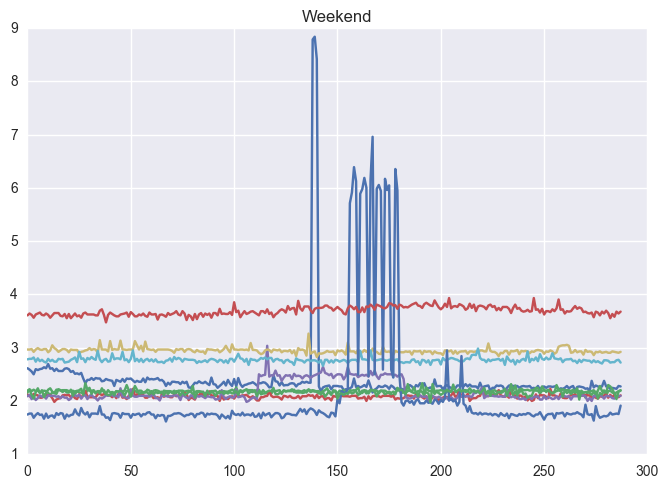

In [371]:
for single_date in daterange(start_date, end_date):
    if single_date.weekday() in [6,7]:
        plt.plot(temp_data[single_date.strftime("%Y-%m-%d")]["___P"].values)
plt.title("Weekend")

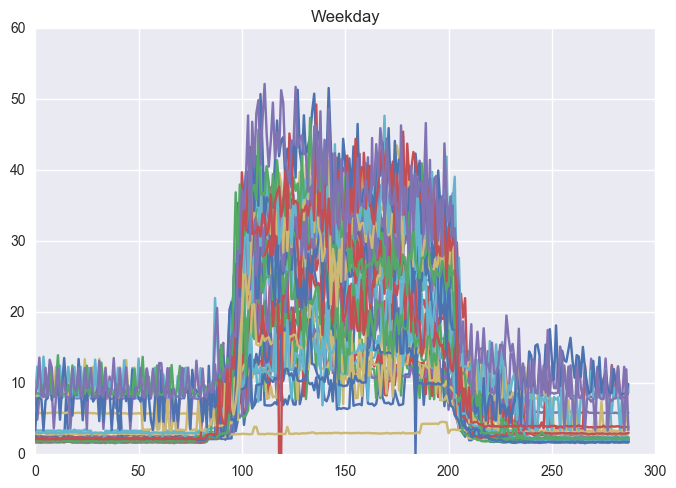

In [372]:
for single_date in daterange(start_date, end_date):
    if single_date.weekday() in [1,2,3,4]:
        plt.plot(temp_data[single_date.strftime("%Y-%m-%d")]["___P"].values)
plt.title("Weekday")

In [289]:
#temp_data["__"] = pd.to_datetime(temp_data["__"])
#temp_data.set_index("__",inplace = True)
#temp_data["___Ua"]
#temp_data['weekday'] = temp_data["Timestamp"].dt.dayofweek
temp_data[temp_data['weekday']==2]["2018-06-06"]
#temp_data

,___Ua,___Ub,___Uc,___Ia,___Ib,___Ic,___P,___Q,___PF,___Ibp,___Ir,___MD,___WP,___WP-,___WQ,___WQ-,weekday,Timestamp
__,,,,,,,,,,,,,,,,,,
2018-06-06 00:00:00,225.960,226.947,226.333,3.08,3.72,6.76,2.571,-0.834,0.958,3.68,0.002,2.496,74048.383,1393.64,8129.13,7848.11,2,2018-06-06 00:00:00
2018-06-06 00:05:00,226.003,226.859,226.245,2.96,3.76,6.76,2.519,-0.825,0.957,3.80,0.002,2.506,74048.547,1393.64,8129.13,7848.16,2,2018-06-06 00:05:00
2018-06-06 00:10:00,225.960,226.815,226.289,2.96,3.76,6.72,2.501,-0.834,0.956,3.76,0.002,2.506,74048.883,1393.64,8129.13,7848.27,2,2018-06-06 00:10:00
2018-06-06 00:15:00,226.025,226.815,226.223,2.96,3.72,6.80,2.527,-0.825,0.957,3.84,0.002,2.506,74049.047,1393.64,8129.13,7848.32,2,2018-06-06 00:15:00
2018-06-06 00:20:00,226.025,226.706,226.179,3.00,3.68,6.64,2.492,-0.834,0.955,3.64,0.002,2.506,74049.219,1393.64,8129.13,7848.38,2,2018-06-06 00:20:00
2018-06-06 00:25:00,226.003,226.706,226.201,2.76,3.68,6.84,2.484,-0.781,0.960,4.08,0.002,2.496,74049.344,1393.64,8129.13,7848.42,2,2018-06-06 00:25:00
2018-06-06 00:30:00,226.223,227.100,226.486,2.92,3.52,6.72,2.466,-0.834,0.954,3.80,0.002,2.487,74049.711,1393.64,8129.13,7848.54,2,2018-06-06 00:30:00
2018-06-06 00:35:00,226.201,226.969,226.398,2.96,3.52,6.72,2.466,-0.842,0.954,3.76,0.002,2.477,74049.883,1393.64,8129.13,7848.60,2,2018-06-06 00:35:00
2018-06-06 00:40:00,226.464,227.166,226.706,2.92,3.44,6.80,2.466,-0.851,0.953,3.88,0.002,2.467,74050.000,1393.64,8129.13,7848.64,2,2018-06-06 00:40:00


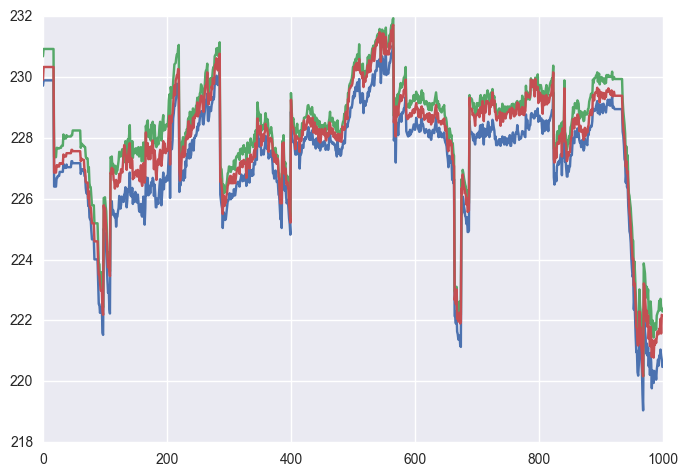

In [3]:
temp = "~/Desktop/equota/申瑞6~8总进线.csv"
temp_data = pd.read_csv(temp)
plt.plot(temp_data['___Ua'][:1000])
plt.plot(temp_data['___Ub'][:1000])
plt.plot(temp_data['___Uc'][:1000])
#

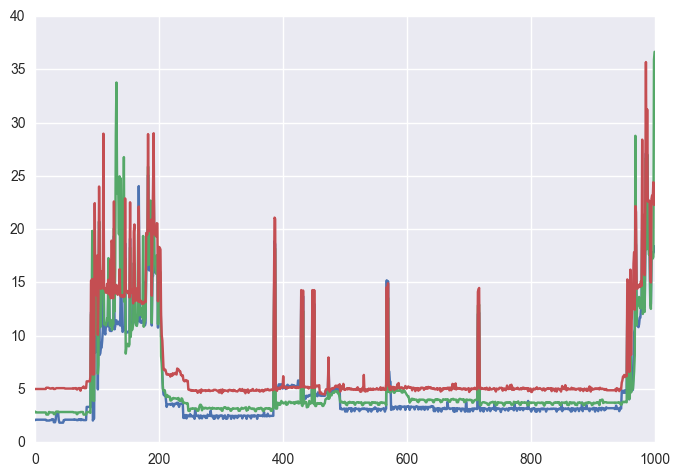

In [4]:
plt.plot(temp_data['___Ia'][:1000])
plt.plot(temp_data['___Ib'][:1000])
plt.plot(temp_data['___Ic'][:1000])
#plt.plot(temp_data['___P'][5000:5500])

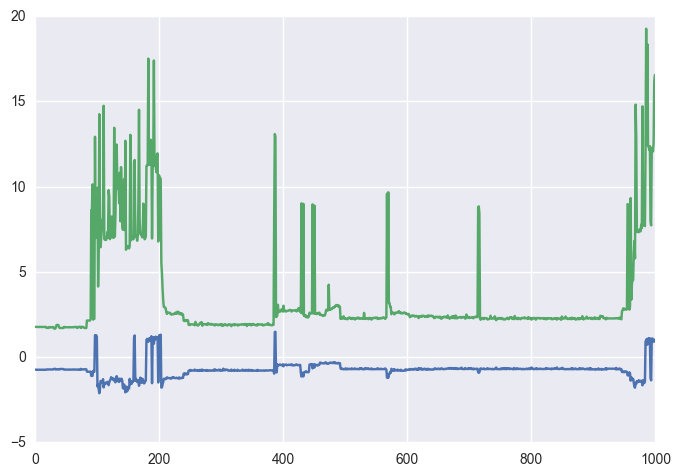

In [5]:
plt.plot(temp_data['___Q'][:1000])
plt.plot(temp_data['___P'][:1000])

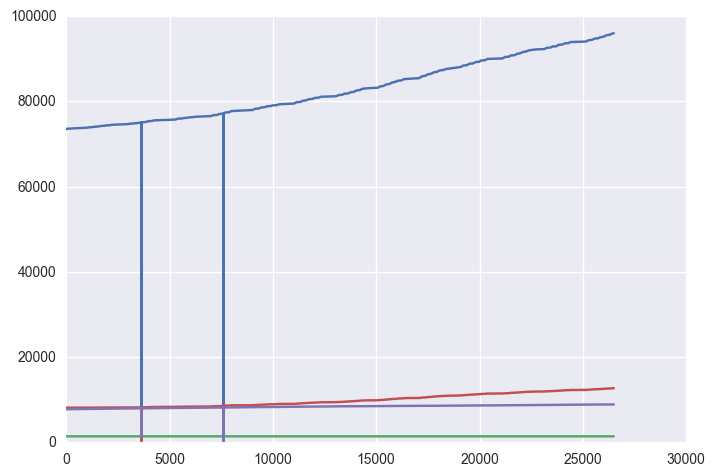

In [6]:
plt.plot(temp_data['___WP'])#[:10000])
plt.plot(temp_data['___WP-'])#[:10000])
plt.plot(temp_data['___WQ'])#[:10000])
plt.plot(temp_data['___WQ-'])#[:10000])

In [7]:
plt.plot(y_all[1*288:2*288] )

NameError: name 'y_all' is not defined

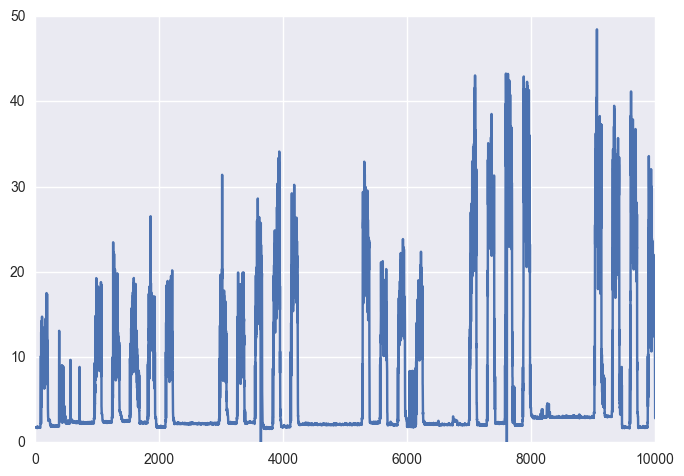

In [254]:
plt.plot(temp_data['___P'][:10000])
#plt.plot(temp_data['___Q'][:1000])
#plt.plot(temp_data['___PF'][:1000])
#plt.plot(temp_data['___Ibp'][:1000])
#plt.plot(temp_data['___Ir'][:1000])
#plt.plot(temp_data['___MD'][:1000])


/Library/Python/2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars


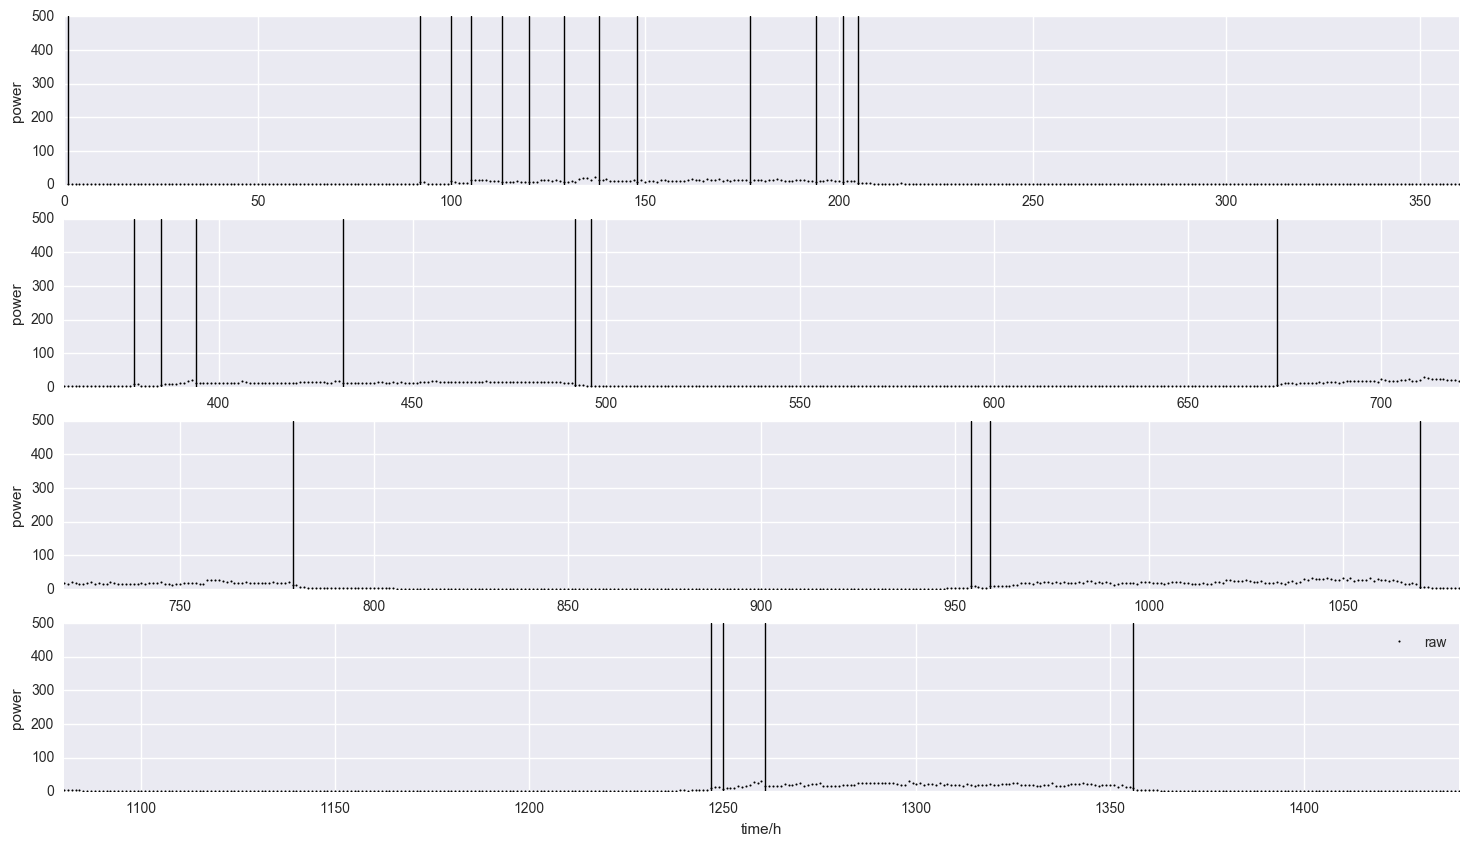

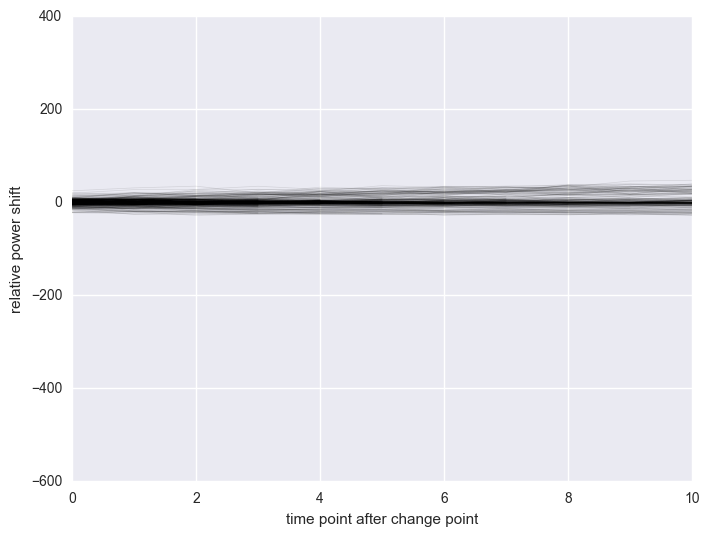

In [72]:
day = 1
period = 2880
y_all = temp_data['___P'].values
t=np.array([i+1 for i in range(period)])
y=y_all[day*period:(day+1)*period]
t_2, y_2 = rel_change_filter_0819_3(t,y)
mu_list_list, sigma_list_list, prob_r_list_list, r_list_list = cp_detect.bayesian_change_point_4(y_2, r_blur=30)
changepoint, changepoint_p = cp_detect.get_change_point(prob_r_list_list)
changepoint.append(len(t_2)-1)
plot_24h_data(t_2,y_2,changepoint)
Computeandplotsegments(t_all = t_all,y_all = y_all,days = 50)

In [456]:
cluster_mean_art  = [[1.57]*3,[6.0]*3,[5.0]*3,[2.37]*3,[4.8]*3,[4.6]*3,[4.48]*3]
name_list = ["JG196空调1570W","FG157热水器6000W","G235高低温交变湿热湿试验箱5000W","JG231美的空调2370W","G7海尔空调4800W","G159空调4600W","G342大金空调4480W"]
name_list = ["JG196/1570W","FG157/6000W","G235/5000W","JG231/2370W","G7/4800W","G159/4600W","G342/4480W"]
cluster_mean_art = [np.array(i) for i in cluster_mean_art]
cluster_mean_art

[array([ 1.57,  1.57,  1.57]),
 array([ 6.,  6.,  6.]),
 array([ 5.,  5.,  5.]),
 array([ 2.37,  2.37,  2.37]),
 array([ 4.8,  4.8,  4.8]),
 array([ 4.6,  4.6,  4.6]),
 array([ 4.48,  4.48,  4.48])]

/Library/Python/2.7/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in double_scalars


3


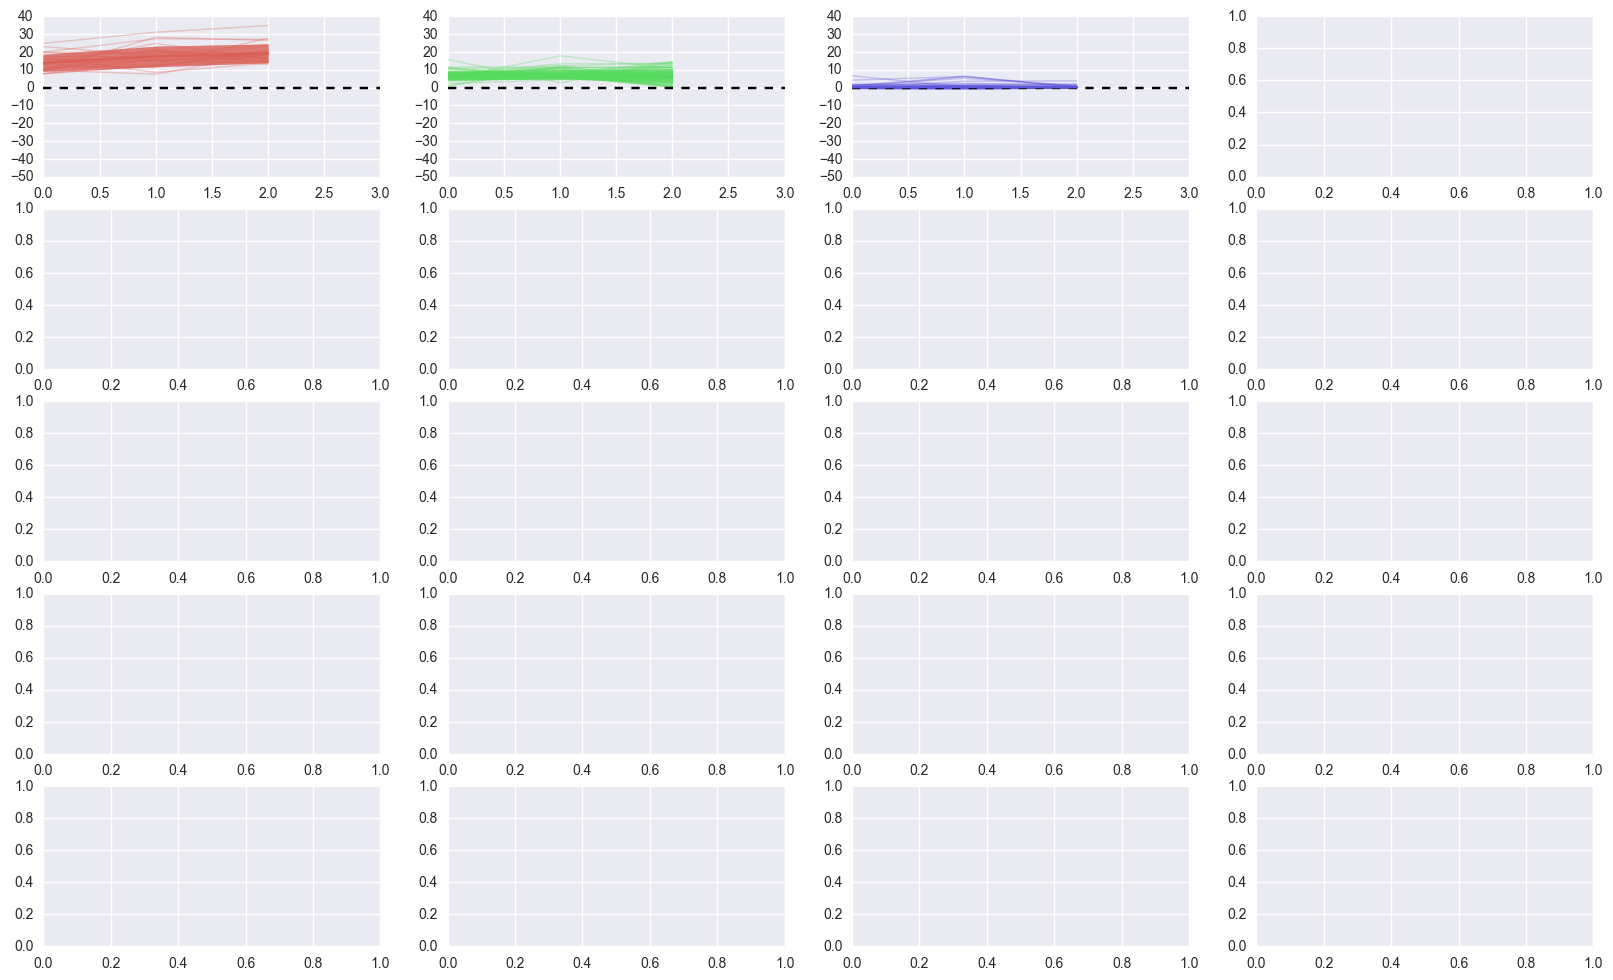

In [119]:
cluster_mean,cluster_std,n_clusters,all_seg_per_cluster = integrated_clustering(t_all,y_all,num_of_days=100,period = 288,trim=3,min_n_clusters = 3, max_n_clusters=5)
#TODO: bug in plot function, not supporting variable length...
plot_cluster_result(cluster_mean,cluster_std,n_clusters,all_seg_per_cluster,trim = 3)

In [30]:
period = 288
day = 54
cluster_mean_2 = cluster_mean
cluster_mean_2 = cluster_mean_art
predicted_profile = integrated_dissagregate(y_all,288,cluster_mean_2,day = day,n_equipment_type = len(cluster_mean_2),n_equipment=[2 for i in range(1,len(cluster_mean_2)+1)],obs_mat=n_dimension_identity_matrix(cluster_mean_2),power_usage = [i.mean() for i in cluster_mean_2],alpha = 100,r_blur = 30)  
#for i in range(len(predicted_profile)):
#    plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))

NameError: name 'cluster_mean' is not defined

In [340]:
print str('用电分解 ')+str((start_date + timedelta(day)).strftime("%Y-%m-%d"))

用电分解 2018-07-25


(0.0, 287.0, 0.0, 23.334377797672335)

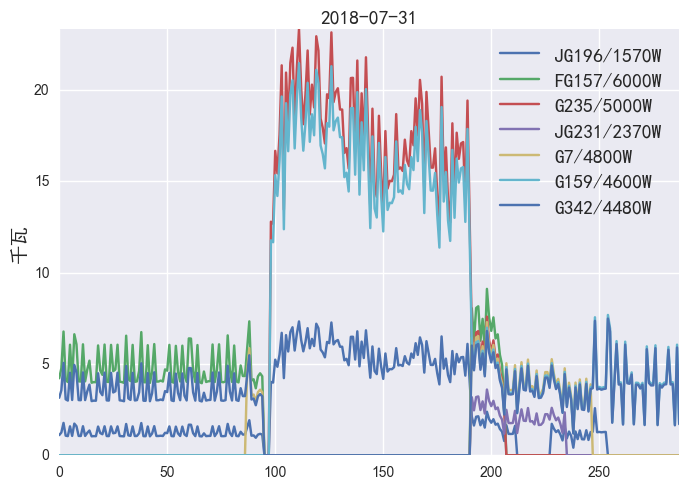

In [457]:
df = pd.DataFrame()
usage = [0]*len(name_list)
for i in range(len(predicted_profile)):
    for point in predicted_profile[i]:
        df[name_list[i]] = predicted_profile[i]
        usage[i] = (1.0/12.0)*sum(predicted_profile[i])

from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

fig = df.plot(kind = 'line')
fig.plot()

# Note the next lines
plt.legend(loc=0, prop=fontP)
plt.title(str((start_date + timedelta(day)).strftime("%Y-%m-%d")), fontproperties=fontP)
plt.ylabel('千瓦'.decode('utf-8'),fontproperties=fontP)
plt.grid(True)
plt.axis('tight')





In [458]:
df.index = temp_data[single_date.strftime("%Y-%m-%d")].index
df

,JG196/1570W,FG157/6000W,G235/5000W,JG231/2370W,G7/4800W,G159/4600W,G342/4480W
__,,,,,,,
2018-07-31 00:00:00,1.103430,4.216929,0.0,0.0,0.0,0.000000,3.148641
2018-07-31 00:05:00,1.246359,4.763154,0.0,0.0,0.0,0.000000,3.556488
2018-07-31 00:10:00,1.772341,6.773278,0.0,0.0,0.0,0.000000,5.057381
2018-07-31 00:15:00,1.073724,4.103402,0.0,0.0,0.0,0.000000,3.063874
2018-07-31 00:20:00,1.049620,4.011286,0.0,0.0,0.0,0.000000,2.995094
2018-07-31 00:25:00,1.583680,6.052282,0.0,0.0,0.0,0.000000,4.519037
2018-07-31 00:30:00,1.061085,4.055104,0.0,0.0,0.0,0.000000,3.027811
2018-07-31 00:35:00,1.733384,6.624398,0.0,0.0,0.0,0.000000,4.946217
2018-07-31 00:40:00,1.589413,6.074191,0.0,0.0,0.0,0.000000,4.535396


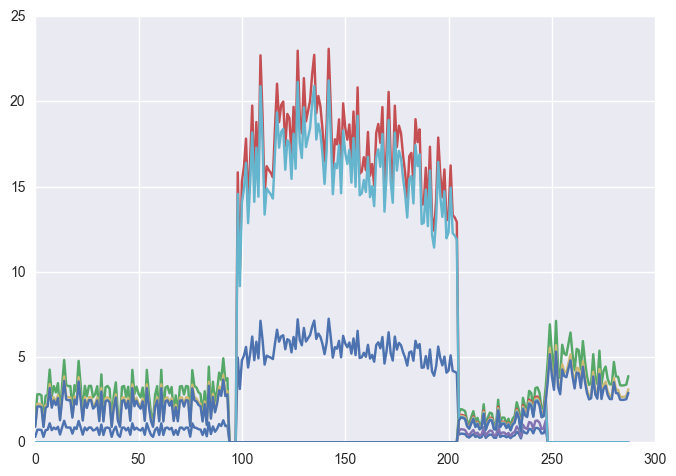

In [316]:
for i in range(len(predicted_profile)):
    #plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))
    plt.plot(predicted_profile[i])
#plt.plot(y_all[1*288:2*288] )


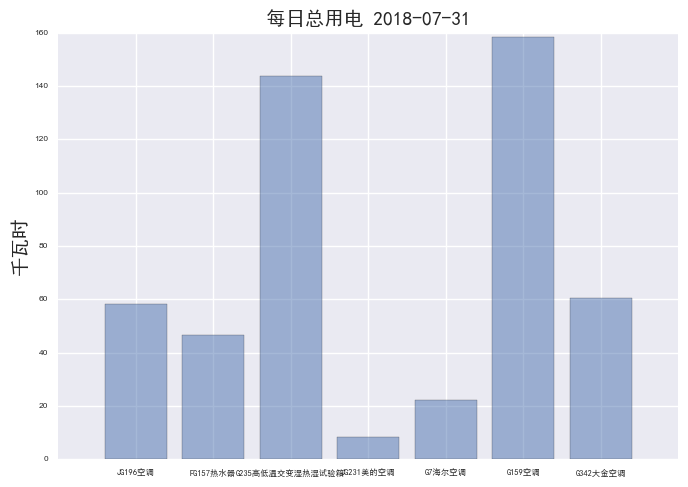

In [459]:
name_list2 = ["JG196空调","FG157热水器","G235高低温交变湿热湿试验箱","JG231美的空调","G7海尔空调","G159空调","G342大金空调"]
y_pos = np.arange(len(name_list2))
performance = usage
plt.legend(loc=0, prop=fontP)
plt.bar(y_pos, performance, align='center', alpha=0.5)

plt.ylabel('千瓦时'.decode('utf-8'),fontproperties=fontP)
plt.title('每日总用电 '.decode('utf-8')+str((start_date + timedelta(day)).strftime("%Y-%m-%d")),fontproperties=fontP )
plt.xticks(y_pos, [i.decode('utf-8') for i in name_list2] ,fontproperties=fontP)
plt.tick_params(labelsize=6)
plt.show()

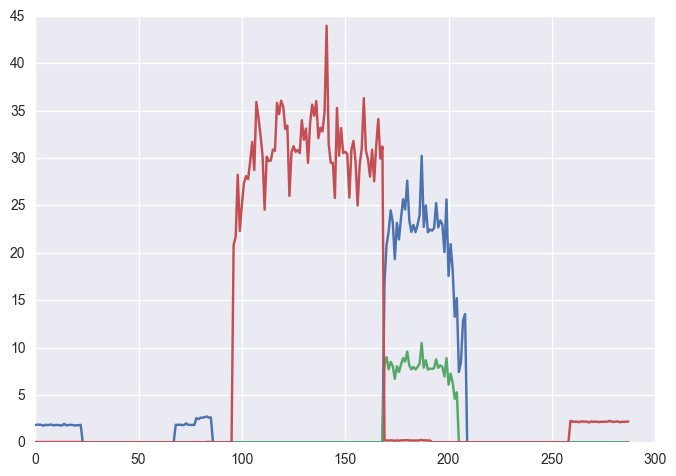

In [242]:
for i in range(len(predicted_profile)):
    #plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))
    plt.plot(predicted_profile[i])
#plt.plot(y_all[1*288:2*288] )


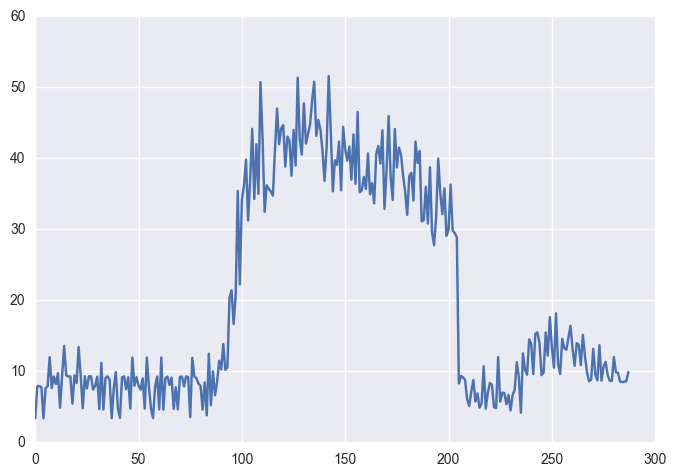

In [251]:
plt.plot(y_all[day*288:(day+1)*288] )

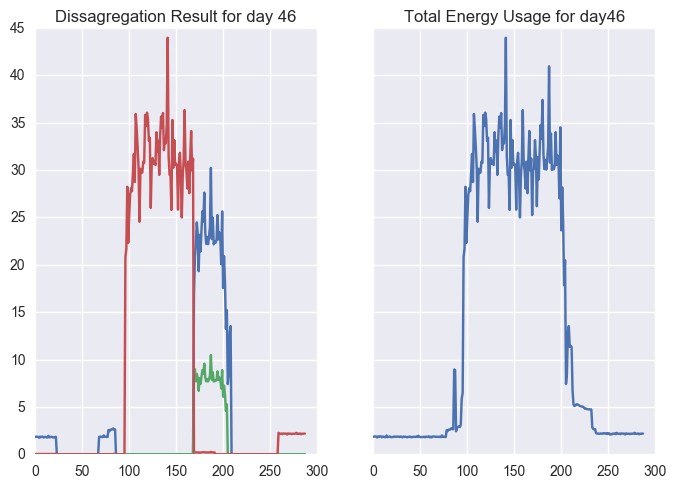

In [209]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(len(predicted_profile)):
    #plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))
    ax1.plot(predicted_profile[i])
ax1.set_title('Dissagregation Result for day '+str(day))
ax2.plot(y_all[day*288:(day+1)*288] )
ax2.set_title('Total Energy Usage for day'+str(day))

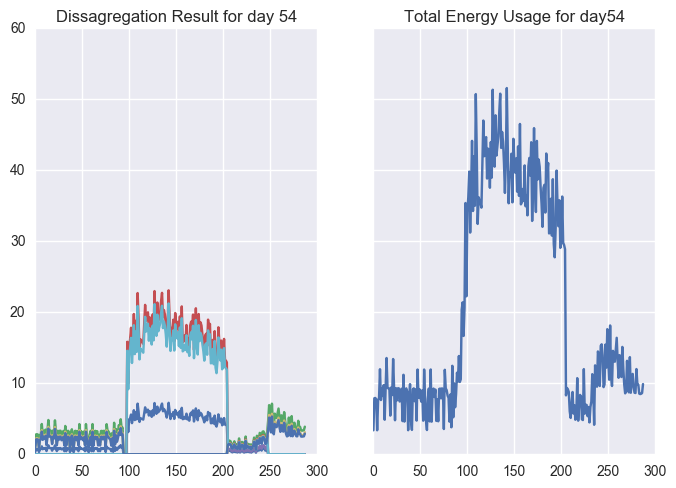

In [324]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for i in range(len(predicted_profile)):
    #plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(period)]))
    ax1.plot(predicted_profile[i])
ax1.set_title('Dissagregation Result for day '+str(day))
ax2.plot(y_all[day*288:(day+1)*288] )
ax2.set_title('Total Energy Usage for day'+str(day))

In [26]:

# TODO: Cluster based on weeday...
# TODO: sqrt(P^2+Q^2)
from matplotlib import font_manager
# Setup
cluster_mean_art  = [[1.57]*3,[6.0]*3,[5.0]*3,[2.37]*3,[4.8]*3,[4.6]*3,[4.48]*3]
name_list = ["JG196空调1570W","FG157热水器6000W","G235高低温交变湿热湿试验箱5000W","JG231美的空调2370W","G7海尔空调4800W","G159空调4600W","G342大金空调4480W"]
name_list = ["JG196/1570W","FG157/6000W","G235/5000W","JG231/2370W","G7/4800W","G159/4600W","G342/4480W"]
cluster_mean_2 = [np.array(i) for i in cluster_mean_art]
 
weekdaylist = [1,2,3,4,5,6,7]
cnt=0
#Integrated generating report for a choosed weekday 
for single_date in daterange(start_date, end_date):
    cnt+=1
    if single_date.weekday() in weekdaylist:
        
        #temp_data[single_date.strftime("%Y-%m-%d")]["___P"].values
        
        #Compute the day
        day = (single_date-start_date).days
        predicted_profile = integrated_dissagregate(y_all,288,cluster_mean_2,day = day,n_equipment_type = len(cluster_mean_2),n_equipment=[2 for i in range(1,len(cluster_mean_2)+1)],obs_mat=n_dimension_identity_matrix(cluster_mean_2),power_usage = [i.mean() for i in cluster_mean_2],alpha = 100,r_blur = 30)  
        
        
        #Plot the dissagregate result:
        df = pd.DataFrame()
        usage = [0]*len(name_list)
        for i in range(len(predicted_profile)):
            for point in predicted_profile[i]:
                df[name_list[i]] = predicted_profile[i]
                usage[i] = (1.0/12.0)*sum(predicted_profile[i])
        df.index = temp_data[single_date.strftime("%Y-%m-%d")].index
        
        fontP = font_manager.FontProperties()
        fontP.set_family('SimHei')
        fontP.set_size(14)

        fig = df.plot(kind = 'line')
        #fig.plot()
        #temp= fig.get_figure()
        #temp.savefig(str((start_date + timedelta(day)).strftime("%Y-%m-%d"))+'.png')
        # Note the next lines
        plt.legend(loc=0, prop=fontP)
        plt.title(str((start_date + timedelta(day)).strftime("%Y-%m-%d")), fontproperties=fontP)

        plt.grid(True)
        plt.axis('tight')
        plt.savefig("TS"+str((start_date + timedelta(day)).strftime("%Y-%m-%d")))
        #Plot the Energy Usage Result
        plt.clf()
        plt.figure(cnt)
        name_list2 = ["JG196空调","FG157热水器","G235高低温交变湿热湿试验箱","JG231美的空调","G7海尔空调","G159空调","G342大金空调"]
        y_pos = np.arange(len(name_list2))
        performance = usage
        plt.legend(loc=0, prop=fontP)
        plt.bar(y_pos, performance, align='center', alpha=0.5)
        
        plt.ylabel('千瓦时'.decode('utf-8'),fontproperties=fontP)
        plt.title('每日总用电 '.decode('utf-8')+str((start_date + timedelta(day)).strftime("%Y-%m-%d")),fontproperties=fontP )
        plt.xticks(y_pos, [i.decode('utf-8') for i in name_list2] ,fontproperties=fontP)
        plt.tick_params(labelsize=6)
        plt.savefig("Stat"+str((start_date + timedelta(day)).strftime("%Y-%m-%d")))
        #plt.show()
        
        #plt.savefig(str((start_date + timedelta(day)).strftime("%Y-%m-%d"))+'.png')
        
        df.to_csv("拆解"+str((start_date + timedelta(day)).strftime("%Y-%m-%d")), encoding='utf_8_sig')
        #print df
        #plt.plot(temp_data[single_date.strftime("%Y-%m-%d")]["___P"].values)

#plt.title("Weekday")

NameError: name 'daterange' is not defined

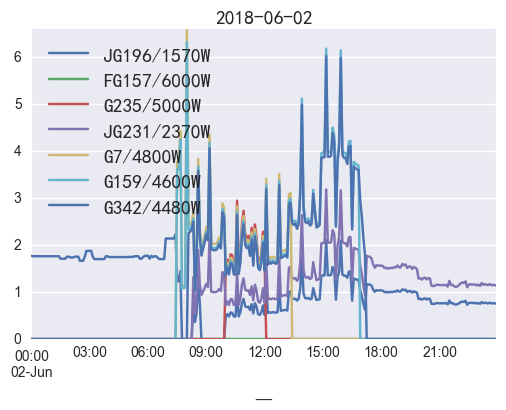

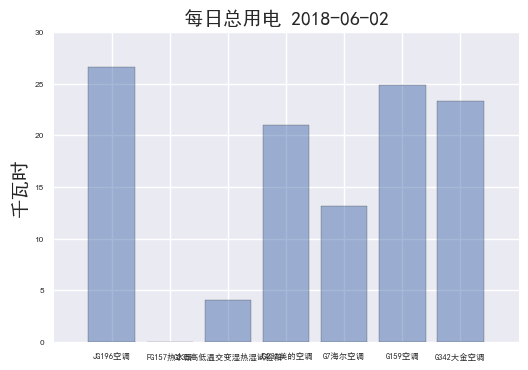

In [494]:
df.index = temp_data[single_date.strftime("%Y-%m-%d")].index
        
fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

fig = df.plot(kind = 'line')
#fig.plot()
temp= fig.get_figure()
temp.savefig(str((start_date + timedelta(day)).strftime("%Y-%m-%d"))+'.png')
# Note the next lines
plt.legend(loc=0, prop=fontP)
plt.title(str((start_date + timedelta(day)).strftime("%Y-%m-%d")), fontproperties=fontP)

plt.grid(True)
plt.axis('tight')
plt.savefig("TS"+str((start_date + timedelta(day)).strftime("%Y-%m-%d")))
#Plot the Energy Usage Result
plt.figure(cnt)
name_list2 = ["JG196空调","FG157热水器","G235高低温交变湿热湿试验箱","JG231美的空调","G7海尔空调","G159空调","G342大金空调"]
y_pos = np.arange(len(name_list2))
performance = usage
plt.legend(loc=0, prop=fontP)
plt.bar(y_pos, performance, align='center', alpha=0.5)

plt.ylabel('千瓦时'.decode('utf-8'),fontproperties=fontP)
plt.title('每日总用电 '.decode('utf-8')+str((start_date + timedelta(day)).strftime("%Y-%m-%d")),fontproperties=fontP )
plt.xticks(y_pos, [i.decode('utf-8') for i in name_list2] ,fontproperties=fontP)
plt.tick_params(labelsize=6)
plt.savefig("Stat"+str((start_date + timedelta(day)).strftime("%Y-%m-%d")))

In [455]:
df.to_csv("拆解2018-07-31", encoding='utf_8_sig')
#df.to_csv("拆解2018-07-31", encoding='gb2312')

[]

In [409]:
import pandas
import matplotlib.pyplot as plt
from pdf_reports import pug_to_html, write_report

dataframe = df.resample("1h")

#html = pug_to_html("with_plots_and_tables.pug", dataframe=dataframe)
#write_report(html, "with_plots_and_tables.pdf")

OSError: dlopen() failed to load a library: cairo / cairo-2 / cairo-gobject-2

In [439]:
"""
This is a demo of creating a pdf file with several pages,
as well as adding metadata and annotations to pdf files.
"""

import datetime
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

# Create the PdfPages object to which we will save the pages:
# The with statement makes sure that the PdfPages object is closed properly at
# the end of the block, even if an Exception occurs.
with PdfPages('multipage_pdf.pdf') as pdf:
    plt.figure(figsize=(3, 3))
    plt.plot(range(7), [3, 1, 4, 1, 5, 9, 2], 'r-o')
    plt.title('Page One')
    pdf.savefig()  # saves the current figure into a pdf page
    plt.close()

    plt.rc('text', usetex=True)
    plt.figure(figsize=(8, 6))
    x = np.arange(0, 5, 0.1)
    plt.plot(x, np.sin(x), 'b-')
    plt.title('Page Two')
    pdf.attach_note("plot of sin(x)")  # you can add a pdf note to
                                       # attach metadata to a page
    pdf.savefig()
    plt.close()

    plt.rc('text', usetex=False)
    fig = plt.figure(figsize=(4, 5))
    plt.plot(x, x*x, 'ko')
    plt.title('Page Three')
    pdf.savefig(fig)  # or you can pass a Figure object to pdf.savefig
    plt.close()

    # We can also set the file's metadata via the PdfPages object:
    d = pdf.infodict()
    d['Title'] = 'Multipage PDF Example'
    d['Author'] = u'Jouni K. Sepp\xe4nen'
    d['Subject'] = 'How to create a multipage pdf file and set its metadata'
    d['Keywords'] = 'PdfPages multipage keywords author title subject'
    d['CreationDate'] = datetime.datetime(2009, 11, 13)
    d['ModDate'] = datetime.datetime.today()


## Test on Equota Data

In [5]:
from influxdb import DataFrameClient
client = DataFrameClient(
    host = "120.132.6.207",
    username = "svcuser",
    password = "svcuser",
    database = "weather"
)
df = client.query("select * from TS2 order by time desc limit 1000")[u'TS2']

In [3]:
# change the following path to your local repository of energyanalytics
mod_path = '/Users/Simo/Documents/EquotaCode/Disaggregation/disaggregation/energyanalytics/source/disaggregation'
import pandas as pd
if not (mod_path in sys.path):
    sys.path.insert(0, mod_path)
import Util
reload(Util)
test = Util.EquotaData()
test.get_appliance_data()
test.compute_total(appliance_list = test.appliance_list)
test_data = pd.concat([test.data[app]["P"].fillna(method='ffill') for app in test.appliance_list], axis=1, keys=test.appliance_list).fillna(method = "ffill").resample("30S").pad().fillna(0)
test_data["total"] = test_data.sum(axis=1)

2018-11-14 02:44:00+00:00       0.0
2018-11-14 02:44:30+00:00    1168.0
2018-11-14 02:45:00+00:00    1168.0
2018-11-14 02:45:30+00:00     674.0
2018-11-14 02:46:00+00:00     674.0
2018-11-14 02:46:30+00:00     776.0
2018-11-14 02:47:00+00:00     776.0
2018-11-14 02:47:30+00:00     233.0
2018-11-14 02:48:00+00:00     233.0
2018-11-14 02:48:30+00:00    1104.0
2018-11-14 02:49:00+00:00    1104.0
2018-11-14 02:49:30+00:00    1447.0
2018-11-14 02:50:00+00:00    1447.0
2018-11-14 02:50:30+00:00    1823.0
2018-11-14 02:51:00+00:00    1823.0
2018-11-14 02:51:30+00:00     674.0
2018-11-14 02:52:00+00:00     674.0
2018-11-14 02:52:30+00:00     241.0
2018-11-14 02:53:00+00:00     241.0
2018-11-14 02:53:30+00:00     233.0
2018-11-14 02:54:00+00:00     233.0
2018-11-14 02:54:30+00:00     233.0
2018-11-14 02:55:00+00:00     233.0
2018-11-14 02:55:30+00:00     234.0
2018-11-14 02:56:00+00:00     234.0
2018-11-14 02:56:30+00:00     234.0
2018-11-14 02:57:00+00:00     234.0
2018-11-14 02:57:30+00:00   

In [7]:
reload(Util)
temp = Util.CombinatorialOptimization({"1":[0,550],"2":[0,40],"3":[0,600],"4":[0,1000]})
temp.power_disaggregate(test_data["total"].values)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [0.0], [1168.0, 1168.0, 674.0, 674.0, 776.0, 776.0, 233.0, 233.0, 1104.0, 1104.0, 1447.0, 1447.0, 1823.0, 1823.0, 674.0, 674.0, 241.0, 241.0, 233.0, 233.0, 233.0, 233.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 234.0, 782.0, 782.0, 782.0, 782.0, 780.0, 780.0, 256.0, 256.0, 2

TypeError: range() integer end argument expected, got numpy.float64.

['2', '3', '4', '6', '11']


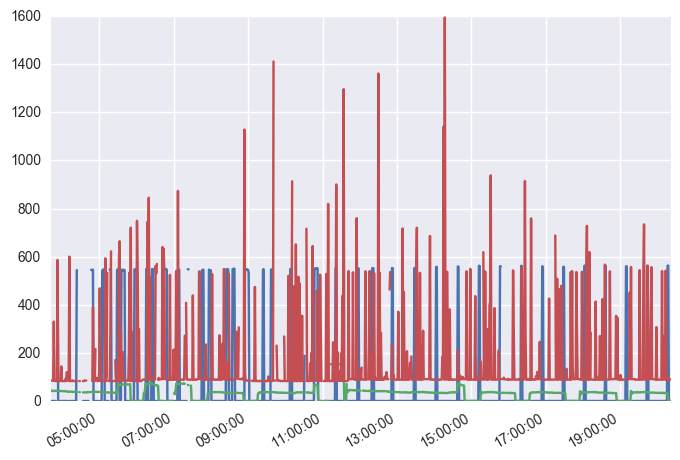

In [18]:
print test.appliance_list
test.data["2"]["P"].plot()
test.data["3"]["P"].plot()
test.data["4"]["P"].plot()
#test.data["6"]["P"].plot()
#test.data["11"]["P"].plot()

In [4]:
test_data = pd.concat([test.data[app]["P"].fillna(method='ffill') for app in test.appliance_list], axis=1, keys=test.appliance_list).fillna(method = "ffill").resample("30S").pad().fillna(0)
test_data["total"] = test_data.sum(axis=1)

In [24]:
test = Util.EquotaData()
test.get_appliance_data()
test.compute_total(appliance_list = test.appliance_list)

2018-11-14 02:18:00+00:00      0.0
2018-11-14 02:18:30+00:00     83.0
2018-11-14 02:19:00+00:00     83.0
2018-11-14 02:19:30+00:00    781.0
2018-11-14 02:20:00+00:00    781.0
2018-11-14 02:20:30+00:00    154.0
2018-11-14 02:21:00+00:00    154.0
2018-11-14 02:21:30+00:00    154.0
2018-11-14 02:22:00+00:00    154.0
2018-11-14 02:22:30+00:00    703.0
2018-11-14 02:23:00+00:00    703.0
2018-11-14 02:23:30+00:00    701.0
2018-11-14 02:24:00+00:00    701.0
2018-11-14 02:24:30+00:00    700.0
2018-11-14 02:25:00+00:00    700.0
2018-11-14 02:25:30+00:00    699.0
2018-11-14 02:26:00+00:00    699.0
2018-11-14 02:26:30+00:00    699.0
2018-11-14 02:27:00+00:00    699.0
2018-11-14 02:27:30+00:00    699.0
2018-11-14 02:28:00+00:00    699.0
2018-11-14 02:28:30+00:00    154.0
2018-11-14 02:29:00+00:00    154.0
2018-11-14 02:29:30+00:00    697.0
2018-11-14 02:30:00+00:00    697.0
2018-11-14 02:30:30+00:00    696.0
2018-11-14 02:31:00+00:00    696.0
2018-11-14 02:31:30+00:00    694.0
2018-11-14 02:32:00+

In [68]:
cluster_mean_art  = [[550]*3,[40]*3,[600]*3,[1000]*3]
y_all = test_data["total"].values

[0, 4, 11, 17, 28, 37, 43, 49, 58, 64, 70, 76, 82, 88, 102, 110, 125, 131, 138, 154, 160, 166, 172, 181, 188, 194, 200, 206, 252, 264, 270, 276, 282, 288, 294, 300, 306, 312, 318, 324, 330, 344, 350, 356, 366, 380, 388, 394, 400, 406, 412, 418, 426, 432, 443, 449, 462, 472, 478, 486, 492, 498, 504, 530, 536, 542, 556, 563, 569, 575, 582, 588, 594, 600, 606, 614, 622, 631, 637, 653, 659, 668, 680, 686, 697, 710, 722, 728, 747, 753, 760, 766, 776, 787, 794, 800, 806, 812, 818, 824, 830, 836, 842, 848, 854, 860, 866, 872, 878, 884, 896, 902, 908, 936, 946, 952, 958, 964, 970, 979, 985, 991, 1004, 1010, 1016, 1038, 1056, 1084, 1092, 1098, 1104, 1110, 1116, 1122, 1130, 1154, 1166, 1172, 1178, 1184, 1228, 1240, 1246, 1252, 1270, 1280, 1288, 1310, 1316, 1322, 1328, 1334, 1340, 1352, 1370, 1378, 1384, 1390, 1418, 1426, 1432, 1444, 1450, 1456, 1464, 1470, 1476, 1483, 1489, 1504, 1510, 1516, 1522, 1528, 1544, 1570, 1576, 1583, 1589, 1598, 1604, 1610, 1650, 1662, 1668, 1674, 1682, 1690, 1696, 170

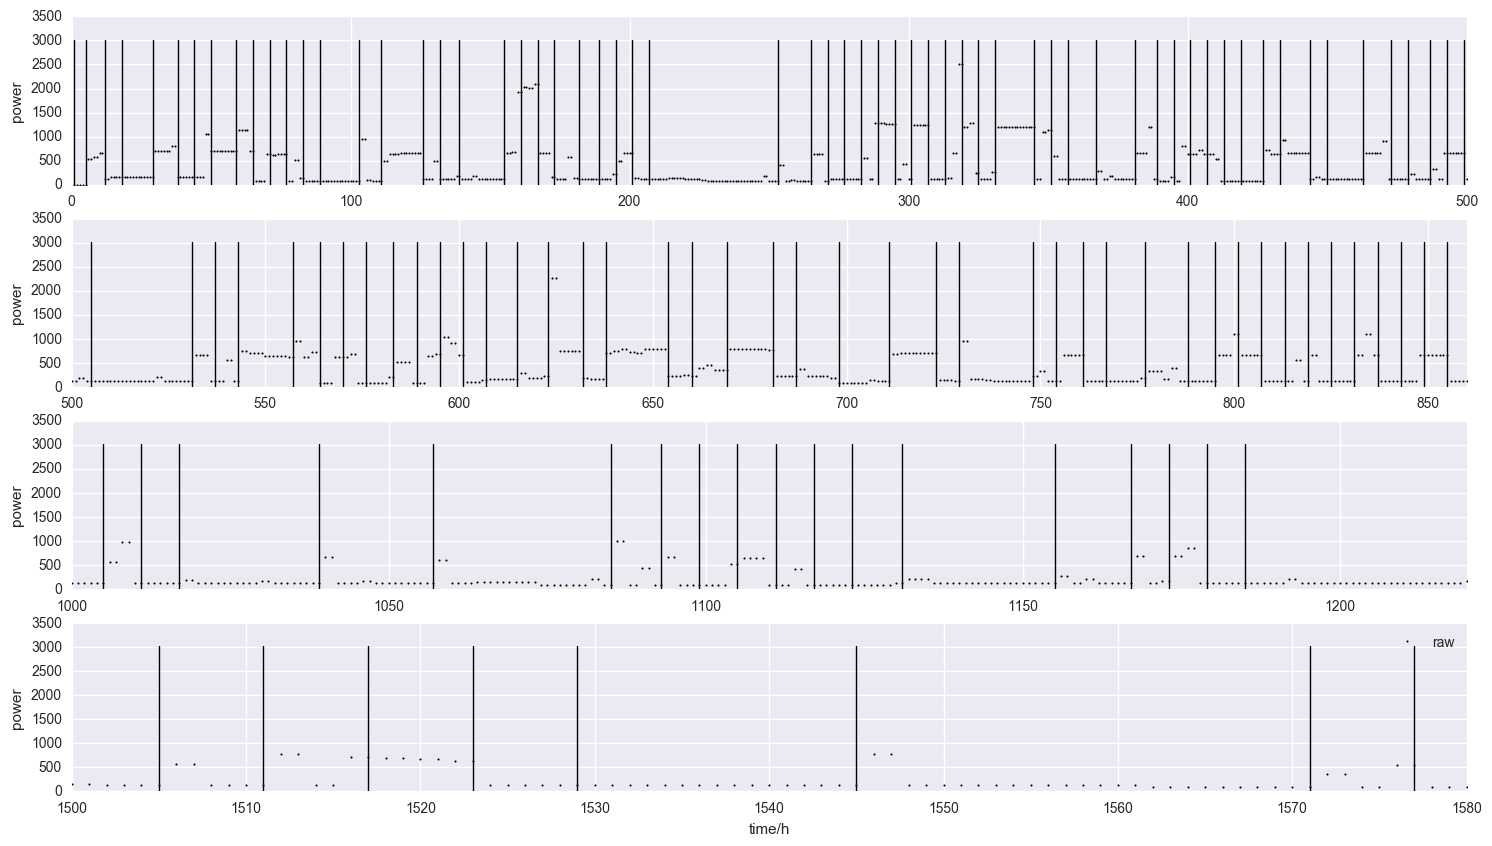

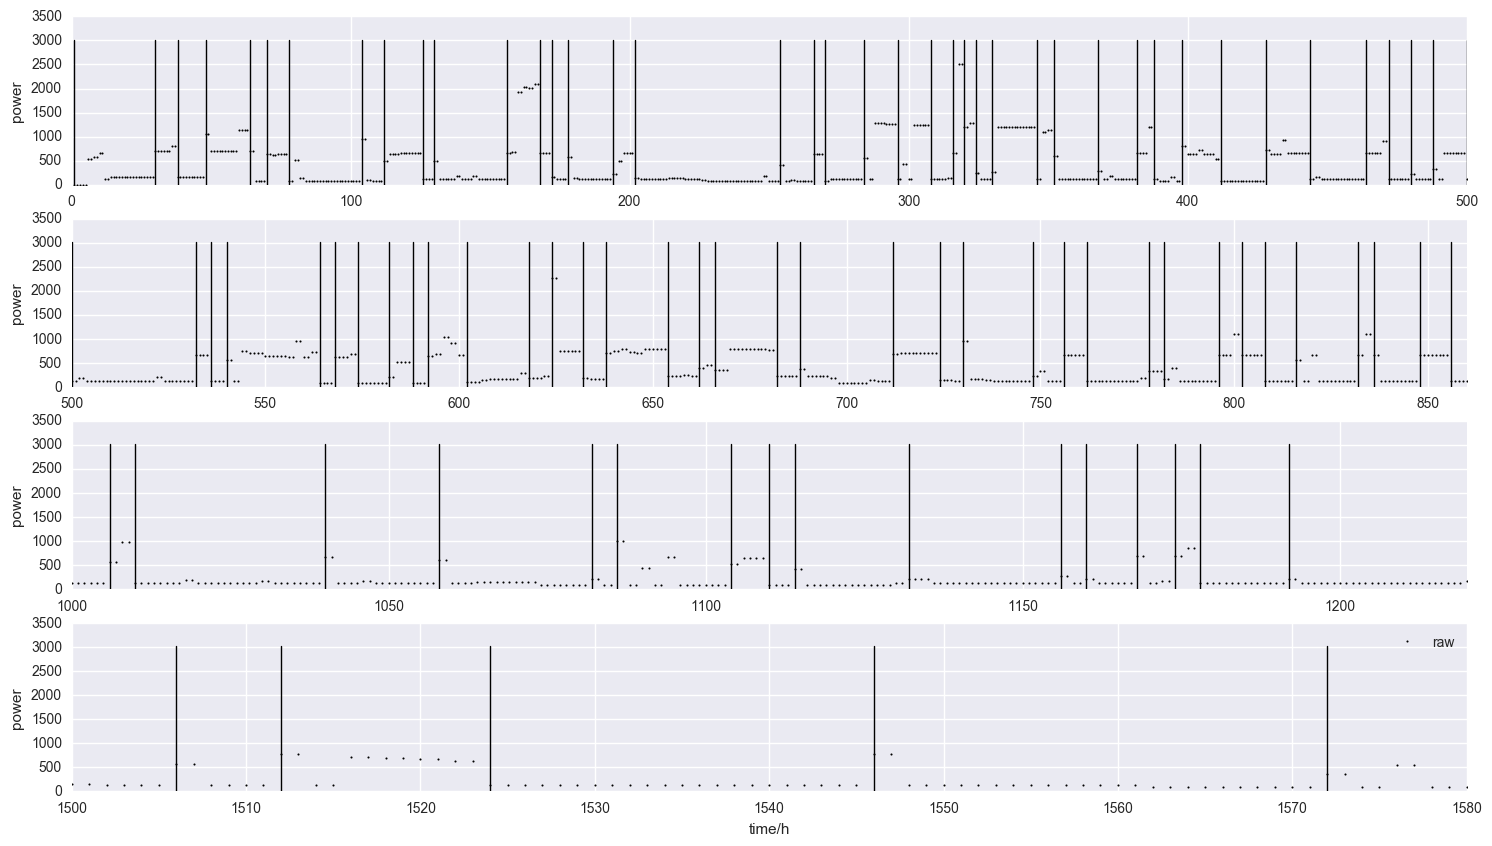

In [69]:
%matplotlib inline 
day = 0
cluster_mean_art = [np.array(i) for i in cluster_mean_art]
cluster_mean_2 = cluster_mean_art
predicted_profile = integrated_dissagregate(y_all,2000,cluster_mean_2,day = day,n_equipment_type = len(cluster_mean_2),n_equipment=[2 for i in range(1,len(cluster_mean_2)+1)],obs_mat=n_dimension_identity_matrix(cluster_mean_2),power_usage = [i.mean() for i in cluster_mean_2],alpha = 100,r_blur = 30)

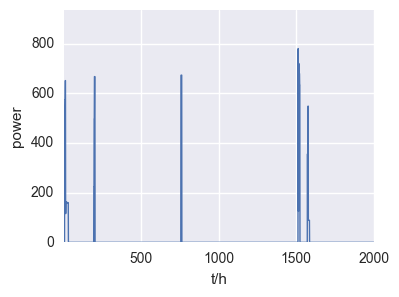

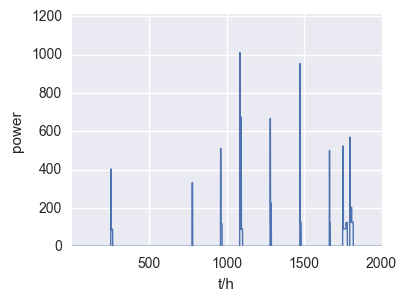

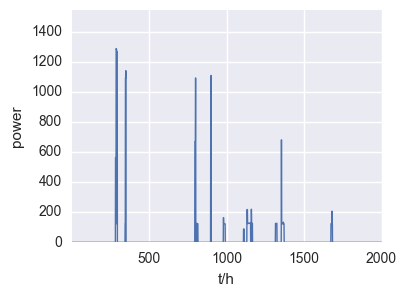

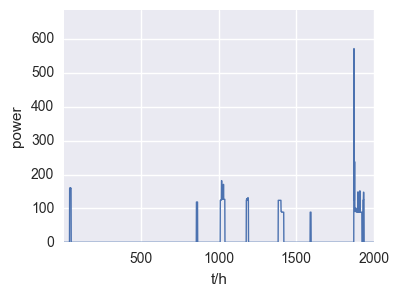

In [70]:
for i in range(len(predicted_profile)):
    plot_dissagregation([predicted_profile[i]],np.array([i+1 for i in range(max(period,len(predicted_profile[i])))]))

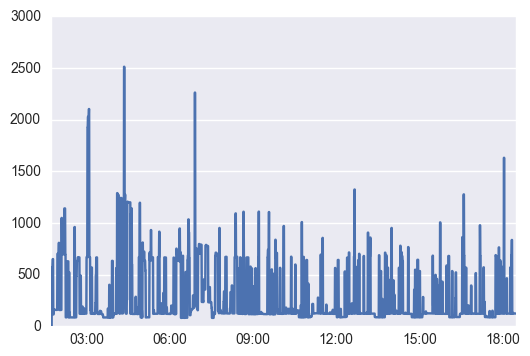

In [53]:
test_data["total"].plot()